<br/>

<center><font size=8px><b>MASTER'S THESIS SCRIPT</b></font></center><br/>
<center><em><font size=5px>Gil Teixeira De Sousa Senecaut</font></em></center><br/>
<center><a href="https://www.uc3m.es/Home"><b><font color=white size=5px>Universidad Carlos III de Madrid</font></b></a></center>
<br/>

<em>This is the script for my Master's Thesis titled ***<font color=#FEF3BD>Deep Learning Approach in Sea Surface Height Forecasting</font>***</em>

<br/>

---
<h3><b>Table of Contents:</b></h3> 

1. <b>Context</b> <br/><br/>
2. <b>Data Acquisition and Manipulation</b> <br/>
&emsp; 2.1. Copernicus Satellite Data <br/>
&emsp; 2.2. Variables Descriptions <br/>
&emsp; 2.3. Data Structuring and Preprocessing <br/><br/>
3. <b>Training, Testing and Comparing Performance</b> <br/>
&emsp; 3.1. Error Metrics <br/>
&emsp; 3.2. LSTM <br/>
&emsp; &emsp; 3.2.1. <em>Number of Epochs</em> <br/>
&emsp; &emsp; 3.2.2. <em>Window Size</em> <br/>
&emsp; &emsp; 3.2.3. <em>Vanilla, Bidirectional and Stacked</em> <br/>
&emsp; 3.3. GRU (Vanilla, Bidirectional and Stacked) <br/>
&emsp; 3.4. 1-Dimensional CNN <br/>
&emsp; 3.5. Evaluating and Comparing Performance <br/>
&emsp; 3.6. Attention Mechanism <br/>
&emsp; 3.7. Increasing Complexity <br/><br/>
4. <b>Shortcomings and Improvements</b>
---

In [1]:
# Imports

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
from cmath import nan
import math
import time
from turtle import color
import warnings
warnings.filterwarnings('ignore')

from attention import Attention
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

import matplotlib.cm as cm
import matplotlib.animation as animation
from ipywidgets import Output, GridspecLayout, Video
from IPython import display

<p style="font-size:25px;"><b>1. Context</b></p>

Some context

<p style="font-size:25px;"><b>2. Data Acquisition and Manipulation</b></p>

<p style="font-size:22px;"> &emsp; &emsp; 2.1. Copernicus Satellite Data</p>

Copernicus data explanation

In [2]:
# Loading Datasets

temp_var = '/Users/Gil Senecaut/Desktop/UC3M/TFM/nc_data_files/cprn_ev_sst (2013-2018).nc'
temp_var = nc.Dataset(temp_var)

wind_vars = '/Users/Gil Senecaut/Desktop/UC3M/TFM/nc_data_files/cprn_ev_ws-ew-nw (2013-2018).nc'
wind_vars = nc.Dataset(wind_vars)

ssh_var = '/Users/Gil Senecaut/Desktop/UC3M/TFM/nc_data_files/cprn_ev_ssh (2017 - 2018).nc'
ssh_var = nc.Dataset(ssh_var)

In [3]:
# Convert Variables to Numpy arrays

### Empty arrays
s = 15 # squares on the grid vertically and horizontally
s_coord = np.arange(1,s+1) 
num_wind_var = 3  # total number of wind related variables

single_year_wv = int(len(wind_vars["time"])/5)
single_year_t = int(len(temp_var["time"])/5)
single_year_ssh = int(len(ssh_var["time"])-1)

northward_wind_a = np.empty((single_year_wv,s,s), dtype=float)
eastward_wind_a = np.empty((single_year_wv,s,s), dtype=float)
wind_stress_a = np.empty((single_year_wv,s,s), dtype=float)
surface_type = np.empty((s,s), dtype=float)
temperature = np.empty((single_year_t,s,s), dtype=float)
sea_surface_height = np.empty((single_year_ssh,s,s), dtype=float)

time_steps_wv = np.empty(single_year_wv, dtype=float)
time_steps_t = np.empty(single_year_t, dtype=float)

### Northward Wind / Eastward Wind / Wind Stress
for h in range(single_year_wv):
    for i in range(num_wind_var):
        if i == 0:
            northward_wind_a[h,:,:] = wind_vars["northward_wind"][-single_year_wv+h,1:,1:]
        elif i == 1:
            eastward_wind_a[h,:,:] = wind_vars["eastward_wind"][-single_year_wv+h,1:,1:]
        elif i == 2:
            wind_stress_a[h,:,:] = wind_vars["wind_stress"][-single_year_wv+h,1:,1:]

northward_wind = np.empty((int(single_year_wv/4), s, s), dtype=float)
eastward_wind = np.empty((int(single_year_wv/4), s, s), dtype=float)
wind_stress = np.empty((int(single_year_wv/4), s, s), dtype=float)
for i in range(int(single_year_wv/4)):
    for j in range(s):
        for k in range(s):
            northward_wind[i,j,k] = np.mean(northward_wind_a[4*i:4*(i+1),j,k])
            eastward_wind[i,j,k] = np.mean(eastward_wind_a[4*i:4*(i+1),j,k])
            wind_stress[i,j,k] = np.mean(wind_stress_a[4*i:4*(i+1),j,k])

### Surface Type
for i in range(s):
    for j in range(s):
            surface_type[i,j] = wind_vars["surface_type"][0,i+1,j+1]
surface_type = surface_type.astype(int)

### Temperature
for i in range(single_year_t):
    temperature[i,:,:] = temp_var["analysed_sst"][-single_year_t+i,:,:-1]

### Sea Surface Height
for i in range(single_year_ssh):
    sea_surface_height[i,:,:] = ssh_var["sla"][-single_year_ssh+i,:,1:]

In [4]:
# Build Dataframe

df = pd.DataFrame({'Time (s)': np.array(temp_var["time"][-365:])})

for i in range(5):
    if i == 0:
        for j in range(s):
            for k in range(s):
                df['Temperature (' + str(j) + ',' + str(k) + ')'] = temperature[:,j,k]
    if i == 1:
        for j in range(s):
            for k in range(s):
                df['Northward Wind (' + str(j) + ',' + str(k) + ')'] = northward_wind[:,j,k]        
    if i == 2:
        for j in range(s):
            for k in range(s):
                df['Eastward Wind (' + str(j) + ',' + str(k) + ')'] = eastward_wind[:,j,k]
    if i == 3:
        for j in range(s):
            for k in range(s):
                df['Wind Stress (' + str(j) + ',' + str(k) + ')'] = wind_stress[:,j,k]
    if i == 4:
        for j in range(s):
            for k in range(s):
                df['Sea Surface Height (' + str(j) + ',' + str(k) + ')'] = sea_surface_height[:,j,k]

year = 365.2425*60*60*24
df['Year sin'] = np.sin(df['Time (s)'] * (2 * np.pi / year))
df['Year cos'] = np.cos(df['Time (s)'] * (2 * np.pi / year))
df = df.drop('Time (s)', axis = 1)

### Drop columns for coordinates with surface type == 1 (land)
for i in range(5):
    if i == 0:
        for j in range(np.shape(np.where(surface_type==1))[1]):
            df = df.drop(['Temperature (' + str(np.where(surface_type==1)[0][j]) + ',' + str(np.where(surface_type==1)[1][j]) + ')'], axis=1)
    if i == 1:
        for j in range(np.shape(np.where(surface_type==1))[1]):
            df = df.drop(['Northward Wind (' + str(np.where(surface_type==1)[0][j]) + ',' + str(np.where(surface_type==1)[1][j]) + ')'], axis=1)        
    if i == 2:
        for j in range(np.shape(np.where(surface_type==1))[1]):
            df = df.drop(['Eastward Wind (' + str(np.where(surface_type==1)[0][j]) + ',' + str(np.where(surface_type==1)[1][j]) + ')'], axis=1)
    if i == 3:
        for j in range(np.shape(np.where(surface_type==1))[1]):
            df = df.drop(['Wind Stress (' + str(np.where(surface_type==1)[0][j]) + ',' + str(np.where(surface_type==1)[1][j]) + ')'], axis=1)
    if i == 4:
        for j in range(np.shape(np.where(surface_type==1))[1]):
            df = df.drop(['Sea Surface Height (' + str(np.where(surface_type==1)[0][j]) + ',' + str(np.where(surface_type==1)[1][j]) + ')'], axis=1)

### SSH at (4,2) all nan
df = df.drop(['Sea Surface Height (4,2)'], axis=1)
df = df.drop(['Temperature (4,2)'], axis=1)
df = df.drop(['Eastward Wind (4,2)'], axis=1)
df = df.drop(['Northward Wind (4,2)'], axis=1)
df = df.drop(['Wind Stress (4,2)'], axis=1)

df = df.copy()

df.head()

,"Temperature (0,2)","Temperature (0,3)","Temperature (0,4)","Temperature (0,5)","Temperature (0,7)","Temperature (0,8)","Temperature (0,9)","Temperature (0,10)","Temperature (0,11)","Temperature (0,12)",...,"Sea Surface Height (14,7)","Sea Surface Height (14,8)","Sea Surface Height (14,9)","Sea Surface Height (14,10)","Sea Surface Height (14,11)","Sea Surface Height (14,12)","Sea Surface Height (14,13)","Sea Surface Height (14,14)",Year sin,Year cos
0,301.419983,301.380005,301.299988,301.190002,301.369995,301.559998,301.759979,302.009979,302.130005,302.149994,...,-0.2507,-0.2418,-0.2396,-0.2366,-0.2305,-0.2230,-0.2155,-0.2103,0.030444,0.999536
1,301.539978,301.479980,301.369995,301.259979,301.559998,301.750000,301.899994,302.089996,302.209991,302.269989,...,-0.2388,-0.2359,-0.2306,-0.2248,-0.2137,-0.2053,-0.2003,-0.1984,0.047634,0.998865
2,301.459991,301.389984,301.269989,301.169983,301.479980,301.729980,301.899994,302.079987,302.190002,302.220001,...,-0.2312,-0.2226,-0.2193,-0.2156,-0.2092,-0.1998,-0.1899,-0.1775,0.064809,0.997898
3,301.410004,301.320007,301.160004,301.029999,301.320007,301.559998,301.720001,301.899994,302.009979,302.049988,...,-0.2150,-0.2146,-0.2134,-0.2127,-0.2048,-0.1948,-0.1789,-0.1625,0.081965,0.996635
4,301.220001,301.139984,300.979980,300.850006,301.070007,301.320007,301.500000,301.690002,301.820007,301.880005,...,-0.2080,-0.2102,-0.2092,-0.2051,-0.1952,-0.1819,-0.1637,-0.1469,0.099097,0.995078


<p style="font-size:22px;"> &emsp; &emsp; 2.2. Variables Descriptions<p>

Variable description

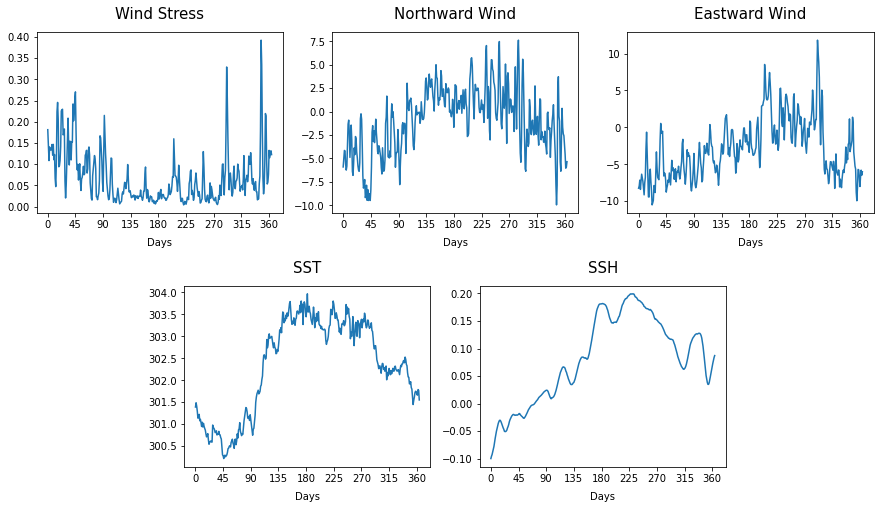

In [5]:
# Mean Variable Plots

mean_temp = []
mean_nw = []
mean_ew = []
mean_ws = []
mean_ssh = []

for i in range(len(df)):
    mean_temp.append(np.mean(df.to_numpy()[i][0:187]))
    mean_nw.append(np.mean(df.to_numpy()[i][187:187*2]))
    mean_ew.append(np.mean(df.to_numpy()[i][187*2:187*3]))
    mean_ws.append(np.mean(df.to_numpy()[i][187*3:187*4]))
    mean_ssh.append(np.mean(df.to_numpy()[i][187*4:187*5]))

fig = plt.figure(figsize=(15,8))
gs = GridSpec(2,6) 

ax0 = plt.subplot(gs[1,1:3])
ax1 = plt.subplot(gs[0,0:2])
ax2 = plt.subplot(gs[0,2:4])
ax3 = plt.subplot(gs[0,4:6])
ax4 = plt.subplot(gs[1,3:5])

ax0.plot(mean_temp)
ax0.set_title("SST", {'fontsize': 15}, pad = 13)
ax0.set_xlabel("Days", loc = "center", labelpad = 8)
ax0.set_xticks(np.arange(0,361,45))
ax1.plot(mean_ws)
ax1.set_title("Wind Stress", {'fontsize': 15}, pad = 13)
ax1.set_xlabel("Days", loc = "center", labelpad = 8)
ax1.set_xticks(np.arange(0,361,45))
ax2.plot(mean_nw)
ax2.set_title("Northward Wind", {'fontsize': 15}, pad = 13)
ax2.set_xlabel("Days", loc = "center", labelpad = 8)
ax2.set_xticks(np.arange(0,361,45))
ax3.plot(mean_ew)       
ax3.set_title("Eastward Wind", {'fontsize': 15}, pad = 13)
ax3.set_xlabel("Days", loc = "center", labelpad = 8)
ax3.set_xticks(np.arange(0,361,45))
ax4.plot(mean_ssh)                     
ax4.set_title("SSH", {'fontsize': 15}, pad = 13)
ax4.set_xlabel("Days", loc = "center", labelpad = 8)
ax4.set_xticks(np.arange(0,361,45))

gs.update(wspace=0.5, hspace=0.4)

plt.show()

<p style="font-size:22px;"> &emsp; &emsp; 2.3. Data Structuring and Preprocessing<p>

Description

In [7]:
# Extract X and y

window_size = 7

def df_to_X_y(df, window_size=window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][748:935].tolist()
    y.append(label)
  return np.array(X), np.array(y)

X1, y1 = df_to_X_y(df)
print('Window size = 7')
print('X shape = ' + str(X1.shape))
print('y shape = ' + str(y1.shape))

Window size = 7
X shape = (358, 7, 937)
y shape = (358, 187)


In [8]:
# Divide into train, validate and test

days = np.shape(X1)[0]
lfw = days-28 # days before the last 4 weeks
lew = days-56 # days before the last 8 weeks

X1_train, y1_train = X1[:lew], y1[:lew]
X1_val, y1_val = X1[lew:lfw], y1[lew:lfw]
X1_test, y1_test = X1[lfw:], y1[lfw:]

print('X_train shape = ' + str(X1_train.shape))
print('y_train shape = ' + str(y1_train.shape))
print('X_val shape = ' + str(X1_val.shape))
print('y_val shape = ' + str(y1_val.shape))
print('X_test shape = ' + str(X1_test.shape))
print('y_test shape = ' + str(y1_test.shape))

X_train shape = (302, 7, 937)
y_train shape = (302, 187)
X_val shape = (28, 7, 937)
y_val shape = (28, 187)
X_test shape = (28, 7, 937)
y_test shape = (28, 187)


In [9]:
# Standardization

ssh_training_mean = np.empty(187, dtype=float)
ssh_training_std = np.empty(187, dtype=float)
stress_training_mean = np.empty(187, dtype=float)
stress_training_std = np.empty(187, dtype=float)
east_training_mean = np.empty(187, dtype=float)
east_training_std = np.empty(187, dtype=float)
north_training_mean = np.empty(187, dtype=float)
north_training_std = np.empty(187, dtype=float)
temp_training_mean = np.empty(187, dtype=float)
temp_training_std = np.empty(187, dtype=float)

for i in range(187):
    ssh_training_mean[i] = np.mean(X1_train[:, :, i+4*187])
    ssh_training_std[i] = np.std(X1_train[:, :, i+4*187])
    stress_training_mean[i] = np.mean(X1_train[:, :, i+3*187])
    stress_training_std[i] = np.std(X1_train[:, :, i+3*187])
    east_training_mean[i] = np.mean(X1_train[:, :, i+2*187])
    east_training_std[i] = np.std(X1_train[:, :, i+2*187])
    north_training_mean[i] = np.mean(X1_train[:, :, i+187])
    north_training_std[i] = np.std(X1_train[:, :, i+187])
    temp_training_mean[i] = np.mean(X1_train[:, :, i])
    temp_training_std[i] = np.std(X1_train[:, :, i])

def preprocess(X,y):
  for i in range(187):
    X[:, :, i+4*187] = (X[:, :, i+4*187] - ssh_training_mean[i]) / ssh_training_std[i]
    X[:, :, i+3*187] = (X[:, :, i+3*187] - stress_training_mean[i]) / stress_training_std[i]
    X[:, :, i+2*187] = (X[:, :, i+2*187] - east_training_mean[i]) / east_training_std[i]
    X[:, :, i+187] = (X[:, :, i+187] - north_training_mean[i]) / north_training_std[i]
    X[:, :, i] = (X[:, :, i] - temp_training_mean[i]) / temp_training_std[i]

    y[:, i] = (y[:, i] - ssh_training_mean[i]) / ssh_training_std[i]

preprocess(X1_train, y1_train)
preprocess(X1_val, y1_val)
preprocess(X1_test, y1_test)

<p style="font-size:25px;"><b>3. Training, Testing and Comparing Performance</b></p>

In [6]:
# Setup

def round_decimals_down(number:float, decimals:int=1):
   
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.floor(number)

    factor = 10 ** decimals
    return math.floor(number * factor) / factor
def round_decimals_up(number:float, decimals:int=2):
    """
    Returns a value rounded up to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.ceil(number)

    factor = 10 ** decimals
    return math.ceil(number * factor) / factor

### Define plot function
def plot_predictions(model, X, y):
  predictions = model.predict(X).flatten()
  MSE = mse(y.flatten(), predictions)
  RMSE = np.sqrt(MSE)
  MAE = mae(y.flatten(), predictions)

  print('MSE = ', str(MSE))
  print('RMSE = ', str(RMSE))
  print('MAE = ', str(MAE))


  fig = plt.figure(figsize=(16,7))
  gs = GridSpec(2,4)

  ax0 = plt.subplot(gs[0,0])
  ax1 = plt.subplot(gs[0,1])
  ax2 = plt.subplot(gs[0,2])
  ax3 = plt.subplot(gs[0,3])
  ax4 = plt.subplot(gs[1,0])
  ax5 = plt.subplot(gs[1,1])
  ax6 = plt.subplot(gs[1,2])
  ax7 = plt.subplot(gs[1,3])

  dfs = np.empty(8, dtype= object)
  mins = np.empty(8, dtype= object)
  maxs = np.empty(8, dtype= object)
  for i in range(8):
    dfs[i] = pd.DataFrame(data={'Predictions':predictions[i::187], 'Actuals':y[:,i]})
    mins[i] = np.min(dfs[i].to_numpy())
    maxs[i] = np.max(dfs[i].to_numpy())

  u = round_decimals_up(np.max(maxs))+0.1
  d = round_decimals_down(np.min(mins))-0.1

  ax0.plot(dfs[0]['Predictions'][:])
  ax0.plot(dfs[0]['Actuals'][:])
  ax0.set_title("Grid"+str(1), {'fontsize': 12}, pad = 10)
  ax0.set_xlabel("Days", loc = "left", labelpad = 5)
  ax0.set_xticks(np.arange(0,29,7))
  ax0.set_ybound(d, u)
  ax1.plot(dfs[1]['Predictions'][:])
  ax1.plot(dfs[1]['Actuals'][:])
  ax1.set_title("Grid"+str(2), {'fontsize': 12}, pad = 10)
  ax1.set_xlabel("Days", loc = "left", labelpad = 5)
  ax1.set_xticks(np.arange(0,29,7))
  ax1.set_ybound(d, u)
  ax2.plot(dfs[2]['Predictions'][:])
  ax2.plot(dfs[2]['Actuals'][:])
  ax2.set_title("Grid"+str(3), {'fontsize': 12}, pad = 10)
  ax2.set_xlabel("Days", loc = "left", labelpad = 5)
  ax2.set_xticks(np.arange(0,29,7))
  ax2.set_ybound(d, u)
  ax3.plot(dfs[3]['Predictions'][:])
  ax3.plot(dfs[3]['Actuals'][:])
  ax3.set_title("Grid"+str(4), {'fontsize': 12}, pad = 10)
  ax3.set_xlabel("Days", loc = "left", labelpad = 5)
  ax3.set_xticks(np.arange(0,29,7))
  ax3.set_ybound(d, u)
  ax4.plot(dfs[4]['Predictions'][:])
  ax4.plot(dfs[4]['Actuals'][:])
  ax4.set_title("Grid"+str(5), {'fontsize': 12}, pad = 10)
  ax4.set_xlabel("Days", loc = "left", labelpad = 5)
  ax4.set_xticks(np.arange(0,29,7))
  ax4.set_ybound(d, u)
  ax5.plot(dfs[5]['Predictions'][:])
  ax5.plot(dfs[5]['Actuals'][:])
  ax5.set_title("Grid"+str(6), {'fontsize': 12}, pad = 10)
  ax5.set_xlabel("Days", loc = "left", labelpad = 5)
  ax5.set_xticks(np.arange(0,29,7))
  ax5.set_ybound(d, u)
  ax6.plot(dfs[6]['Predictions'][:])
  ax6.plot(dfs[6]['Actuals'][:])
  ax6.set_title("Grid"+str(7), {'fontsize': 12}, pad = 10)
  ax6.set_xlabel("Days", loc = "left", labelpad = 5)
  ax6.set_xticks(np.arange(0,29,7))
  ax6.set_ybound(d, u)
  ax7.plot(dfs[7]['Predictions'][:])
  ax7.plot(dfs[7]['Actuals'][:])
  ax7.set_title("Grid"+str(8), {'fontsize': 12}, pad = 10)
  ax7.set_xlabel("Days", loc = "left", labelpad = 5)
  ax7.set_xticks(np.arange(0,29,7))
  ax7.set_ybound(d, u)

  gs.update(wspace=0.3, hspace=0.4)

### Define loss history callback
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))


<p style="font-size:22px;"> &emsp; &emsp; 3.1. Error Metrics</p>

Error metrics description

<p style="font-size:22px;"> &emsp; &emsp; 3.2. LSTM</p>

LSTM description

In [10]:
vlstm_model_ws7_e50 = Sequential()
vlstm_model_ws7_e50.add(InputLayer((window_size, 937)))
vlstm_model_ws7_e50.add(LSTM(640))
vlstm_model_ws7_e50.add(Dense(320, 'relu'))
vlstm_model_ws7_e50.add(Dense(187, 'linear'))

vlstm_model_ws7_e50.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 640)               4039680   
                                                                 
 dense (Dense)               (None, 320)               205120    
                                                                 
 dense_1 (Dense)             (None, 187)               60027     
                                                                 
Total params: 4,304,827
Trainable params: 4,304,827
Non-trainable params: 0
_________________________________________________________________


In [11]:
cp1 = ModelCheckpoint('vlstm_model_ws7_e50/', save_best_only=True)
lh1 = LossHistory()
vlstm_model_ws7_e50.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
vlstm_model_ws7_e50.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=50, verbose = 0, callbacks=[cp1, lh1])
vlstm_model_ws7_e50 = load_model('vlstm_model_ws7_e50/')

INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets


INFO:tensorflow:Assets written to: vlstm_model_ws7_e50\assets



<p style="font-size:18px;"> &emsp; &emsp; &emsp; &emsp; <em>3.2.1. Number of Epochs</em></p>

Number of epochs description

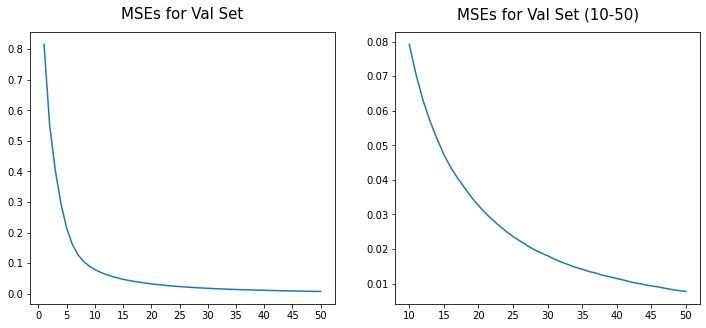

In [12]:
ax0_xlab = [str(n) for n in np.arange(1,52,5)-1]
ax1_xlab = [str(n) for n in np.arange(11,52,5)-1]
losses = [nan] + lh1.losses

fig = plt.figure(figsize=(12,5))
gs = GridSpec(1,2) 

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

ax0.plot(losses)
ax0.set_xticks(np.arange(0,51,5).tolist());ax0.set_xticklabels(ax0_xlab)
ax0.set_title("MSEs for Val Set", {'fontsize': 15}, pad = 13)
ax1.plot(losses[10:])
ax1.set_xticks(np.arange(0,41,5));ax1.set_xticklabels(ax1_xlab)
ax1.set_title("MSEs for Val Set (10-50)", {'fontsize': 15}, pad = 13)

gs.update(wspace=0.2)

plt.show()

<p style="font-size:18px;"> &emsp; &emsp; &emsp; &emsp; <em>3.2.2. Window Size</em></p>

Window size description

In [13]:
df_err_ws = pd.DataFrame(data={'Metrics':['MSE','RMSE','MAE','MAPE','Time (s)']})

win_sizes = np.arange(1,11)[::-1]

for ws in win_sizes:

    def df_to_X_y(df, window_size=ws):
        df_as_np = df.to_numpy()
        X = []
        y = []
        for i in range(len(df_as_np)-window_size):
          row = [r for r in df_as_np[i:i+window_size]]
          X.append(row)
          label = df_as_np[i+window_size][748:935].tolist()
          y.append(label)
        return np.array(X), np.array(y)

    X1, y1 = df_to_X_y(df)

    days = np.shape(X1)[0]
    lfw = days-28 # days before the last 4 weeks
    lew = days-56 # days before the last 8 weeks

    X1_train, y1_train = X1[:lew], y1[:lew]
    X1_val, y1_val = X1[lew:lfw], y1[lew:lfw]
    X1_test, y1_test = X1[lfw:], y1[lfw:]

    ssh_training_mean = np.empty(187, dtype=float)
    ssh_training_std = np.empty(187, dtype=float)
    stress_training_mean = np.empty(187, dtype=float)
    stress_training_std = np.empty(187, dtype=float)
    east_training_mean = np.empty(187, dtype=float)
    east_training_std = np.empty(187, dtype=float)
    north_training_mean = np.empty(187, dtype=float)
    north_training_std = np.empty(187, dtype=float)
    temp_training_mean = np.empty(187, dtype=float)
    temp_training_std = np.empty(187, dtype=float)
    
    for i in range(187):
        ssh_training_mean[i] = np.mean(X1_train[:, :, i+4*187])
        ssh_training_std[i] = np.std(X1_train[:, :, i+4*187])
        stress_training_mean[i] = np.mean(X1_train[:, :, i+3*187])
        stress_training_std[i] = np.std(X1_train[:, :, i+3*187])
        east_training_mean[i] = np.mean(X1_train[:, :, i+2*187])
        east_training_std[i] = np.std(X1_train[:, :, i+2*187])
        north_training_mean[i] = np.mean(X1_train[:, :, i+187])
        north_training_std[i] = np.std(X1_train[:, :, i+187])
        temp_training_mean[i] = np.mean(X1_train[:, :, i])
        temp_training_std[i] = np.std(X1_train[:, :, i])
    
    def preprocess(X,y):
      for i in range(187):
        X[:, :, i+4*187] = (X[:, :, i+4*187] - ssh_training_mean[i]) / ssh_training_std[i]
        X[:, :, i+3*187] = (X[:, :, i+3*187] - stress_training_mean[i]) / stress_training_std[i]
        X[:, :, i+2*187] = (X[:, :, i+2*187] - east_training_mean[i]) / east_training_std[i]
        X[:, :, i+187] = (X[:, :, i+187] - north_training_mean[i]) / north_training_std[i]
        X[:, :, i] = (X[:, :, i] - temp_training_mean[i]) / temp_training_std[i]
    
        y[:, i] = (y[:, i] - ssh_training_mean[i]) / ssh_training_std[i]
    
    preprocess(X1_train, y1_train)
    preprocess(X1_val, y1_val)
    preprocess(X1_test, y1_test)

    start = time.time()

    vlstm_model = Sequential()
    vlstm_model.add(InputLayer((ws, 937)))
    vlstm_model.add(LSTM(640))
    vlstm_model.add(Dense(320, 'relu'))
    vlstm_model.add(Dense(187, 'linear'))

    cp1 = ModelCheckpoint('vlstm_model/', save_best_only=True)
    vlstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
    vlstm_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp1])
    vlstm_model = load_model('vlstm_model/')

    end = time.time()

    predictions = vlstm_model.predict(X1_test).flatten()
    df_err_ws['Win Size ' + str(ws)] = [mse(y1_test.flatten(), predictions),
                                        np.sqrt(mse(y1_test.flatten(), predictions)),
                                        mae(y1_test.flatten(), predictions),
                                        mape(y1_test.flatten(), predictions),
                                        end-start]

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.7843 - root_mean_squared_error: 0.8856

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 533ms/step - loss: 0.7843 - root_mean_squared_error: 0.8856 - val_loss: 0.4750 - val_root_mean_squared_error: 0.6892
Epoch 2/25
10/10 [==============================] - 2s 196ms/step - loss: 0.5194 - root_mean_squared_error: 0.7207 - val_loss: 0.5447 - val_root_mean_squared_error: 0.7380
Epoch 3/25
10/10 [==============================] - 2s 164ms/step - loss: 0.3682 - root_mean_squared_error: 0.6068 - val_loss: 0.5677 - val_root_mean_squared_error: 0.7535
Epoch 4/25
10/10 [==============================] - 2s 161ms/step - loss: 0.2650 - root_mean_squared_error: 0.5148 - val_loss: 0.5573 - val_root_mean_squared_error: 0.7465
Epoch 5/25
10/10 [==============================] - 2s 159ms/step - loss: 0.1954 - root_mean_squared_error: 0.4420 - val_loss: 0.5352 - val_root_mean_squared_error: 0.7315
Epoch 6/25
10/10 [==============================] - 2s 159ms/step - loss: 0.1471 - root_mean_squared_error: 0.3835 - val_loss: 0.5058 - val_root_mean_s

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 504ms/step - loss: 0.0983 - root_mean_squared_error: 0.3136 - val_loss: 0.4569 - val_root_mean_squared_error: 0.6760
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.0846 - root_mean_squared_error: 0.2908

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 509ms/step - loss: 0.0846 - root_mean_squared_error: 0.2908 - val_loss: 0.4407 - val_root_mean_squared_error: 0.6638
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0738 - root_mean_squared_error: 0.2717

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 516ms/step - loss: 0.0738 - root_mean_squared_error: 0.2717 - val_loss: 0.4284 - val_root_mean_squared_error: 0.6545
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0654 - root_mean_squared_error: 0.2558

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 547ms/step - loss: 0.0654 - root_mean_squared_error: 0.2558 - val_loss: 0.4167 - val_root_mean_squared_error: 0.6455
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0582 - root_mean_squared_error: 0.2413

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 580ms/step - loss: 0.0582 - root_mean_squared_error: 0.2413 - val_loss: 0.4067 - val_root_mean_squared_error: 0.6378
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0523 - root_mean_squared_error: 0.2287

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 727ms/step - loss: 0.0523 - root_mean_squared_error: 0.2287 - val_loss: 0.3938 - val_root_mean_squared_error: 0.6276
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0474 - root_mean_squared_error: 0.2177

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 553ms/step - loss: 0.0474 - root_mean_squared_error: 0.2177 - val_loss: 0.3894 - val_root_mean_squared_error: 0.6240
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0432 - root_mean_squared_error: 0.2079

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 557ms/step - loss: 0.0432 - root_mean_squared_error: 0.2079 - val_loss: 0.3864 - val_root_mean_squared_error: 0.6216
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0395 - root_mean_squared_error: 0.1988

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 526ms/step - loss: 0.0395 - root_mean_squared_error: 0.1988 - val_loss: 0.3767 - val_root_mean_squared_error: 0.6137
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0366 - root_mean_squared_error: 0.1913

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 554ms/step - loss: 0.0366 - root_mean_squared_error: 0.1913 - val_loss: 0.3740 - val_root_mean_squared_error: 0.6115
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0337 - root_mean_squared_error: 0.1837

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 524ms/step - loss: 0.0337 - root_mean_squared_error: 0.1837 - val_loss: 0.3665 - val_root_mean_squared_error: 0.6054
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0314 - root_mean_squared_error: 0.1771

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 550ms/step - loss: 0.0314 - root_mean_squared_error: 0.1771 - val_loss: 0.3639 - val_root_mean_squared_error: 0.6032
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0292 - root_mean_squared_error: 0.1710

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 527ms/step - loss: 0.0292 - root_mean_squared_error: 0.1710 - val_loss: 0.3602 - val_root_mean_squared_error: 0.6001
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0272 - root_mean_squared_error: 0.1650

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 551ms/step - loss: 0.0272 - root_mean_squared_error: 0.1650 - val_loss: 0.3531 - val_root_mean_squared_error: 0.5942
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0255 - root_mean_squared_error: 0.1598

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 522ms/step - loss: 0.0255 - root_mean_squared_error: 0.1598 - val_loss: 0.3500 - val_root_mean_squared_error: 0.5916
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0239 - root_mean_squared_error: 0.1548

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 612ms/step - loss: 0.0239 - root_mean_squared_error: 0.1548 - val_loss: 0.3448 - val_root_mean_squared_error: 0.5872
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0225 - root_mean_squared_error: 0.1501

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 586ms/step - loss: 0.0225 - root_mean_squared_error: 0.1501 - val_loss: 0.3428 - val_root_mean_squared_error: 0.5855
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0213 - root_mean_squared_error: 0.1458

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 555ms/step - loss: 0.0213 - root_mean_squared_error: 0.1458 - val_loss: 0.3416 - val_root_mean_squared_error: 0.5845
Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.7787 - root_mean_squared_error: 0.8824

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 568ms/step - loss: 0.7787 - root_mean_squared_error: 0.8824 - val_loss: 0.4752 - val_root_mean_squared_error: 0.6893
Epoch 2/25
10/10 [==============================] - 2s 195ms/step - loss: 0.4983 - root_mean_squared_error: 0.7059 - val_loss: 0.5691 - val_root_mean_squared_error: 0.7544
Epoch 3/25
10/10 [==============================] - 2s 159ms/step - loss: 0.3565 - root_mean_squared_error: 0.5971 - val_loss: 0.6057 - val_root_mean_squared_error: 0.7782
Epoch 4/25
10/10 [==============================] - 2s 159ms/step - loss: 0.2572 - root_mean_squared_error: 0.5072 - val_loss: 0.6043 - val_root_mean_squared_error: 0.7774
Epoch 5/25
10/10 [==============================] - 2s 154ms/step - loss: 0.1889 - root_mean_squared_error: 0.4347 - val_loss: 0.6086 - val_root_mean_squared_error: 0.7801
Epoch 6/25
10/10 [==============================] - 2s 157ms/step - loss: 0.1442 - root_mean_squared_error: 0.3797 - val_loss: 0.5933 - val_root_mean_s

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 475ms/step - loss: 0.0571 - root_mean_squared_error: 0.2389 - val_loss: 0.4687 - val_root_mean_squared_error: 0.6846
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0511 - root_mean_squared_error: 0.2260

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 550ms/step - loss: 0.0511 - root_mean_squared_error: 0.2260 - val_loss: 0.4570 - val_root_mean_squared_error: 0.6760
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0462 - root_mean_squared_error: 0.2150

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 509ms/step - loss: 0.0462 - root_mean_squared_error: 0.2150 - val_loss: 0.4499 - val_root_mean_squared_error: 0.6707
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0421 - root_mean_squared_error: 0.2051

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 546ms/step - loss: 0.0421 - root_mean_squared_error: 0.2051 - val_loss: 0.4420 - val_root_mean_squared_error: 0.6648
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0386 - root_mean_squared_error: 0.1965

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 557ms/step - loss: 0.0386 - root_mean_squared_error: 0.1965 - val_loss: 0.4337 - val_root_mean_squared_error: 0.6586
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0357 - root_mean_squared_error: 0.1889

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 639ms/step - loss: 0.0357 - root_mean_squared_error: 0.1889 - val_loss: 0.4329 - val_root_mean_squared_error: 0.6580
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0330 - root_mean_squared_error: 0.1816

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 517ms/step - loss: 0.0330 - root_mean_squared_error: 0.1816 - val_loss: 0.4236 - val_root_mean_squared_error: 0.6508
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0306 - root_mean_squared_error: 0.1751

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 590ms/step - loss: 0.0306 - root_mean_squared_error: 0.1751 - val_loss: 0.4231 - val_root_mean_squared_error: 0.6504
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0286 - root_mean_squared_error: 0.1690

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 554ms/step - loss: 0.0286 - root_mean_squared_error: 0.1690 - val_loss: 0.4183 - val_root_mean_squared_error: 0.6468
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0269 - root_mean_squared_error: 0.1639

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 515ms/step - loss: 0.0269 - root_mean_squared_error: 0.1639 - val_loss: 0.4125 - val_root_mean_squared_error: 0.6422
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0252 - root_mean_squared_error: 0.1587

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 553ms/step - loss: 0.0252 - root_mean_squared_error: 0.1587 - val_loss: 0.4044 - val_root_mean_squared_error: 0.6359
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0236 - root_mean_squared_error: 0.1537

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 542ms/step - loss: 0.0236 - root_mean_squared_error: 0.1537 - val_loss: 0.3995 - val_root_mean_squared_error: 0.6321
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0222 - root_mean_squared_error: 0.1488

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 551ms/step - loss: 0.0222 - root_mean_squared_error: 0.1488 - val_loss: 0.3958 - val_root_mean_squared_error: 0.6291
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0210 - root_mean_squared_error: 0.1448

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 517ms/step - loss: 0.0210 - root_mean_squared_error: 0.1448 - val_loss: 0.3912 - val_root_mean_squared_error: 0.6254
Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8072 - root_mean_squared_error: 0.8984

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 694ms/step - loss: 0.8072 - root_mean_squared_error: 0.8984 - val_loss: 0.4435 - val_root_mean_squared_error: 0.6660
Epoch 2/25
10/10 [==============================] - 2s 236ms/step - loss: 0.5066 - root_mean_squared_error: 0.7117 - val_loss: 0.5565 - val_root_mean_squared_error: 0.7460
Epoch 3/25
10/10 [==============================] - 2s 182ms/step - loss: 0.3605 - root_mean_squared_error: 0.6004 - val_loss: 0.6314 - val_root_mean_squared_error: 0.7946
Epoch 4/25
10/10 [==============================] - 2s 193ms/step - loss: 0.2626 - root_mean_squared_error: 0.5124 - val_loss: 0.6439 - val_root_mean_squared_error: 0.8024
Epoch 5/25
10/10 [==============================] - 2s 177ms/step - loss: 0.1955 - root_mean_squared_error: 0.4422 - val_loss: 0.6248 - val_root_mean_squared_error: 0.7905
Epoch 6/25
10/10 [==============================] - 2s 212ms/step - loss: 0.1525 - root_mean_squared_error: 0.3905 - val_loss: 0.5754 - val_root_mean_s

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 814ms/step - loss: 0.0804 - root_mean_squared_error: 0.2835 - val_loss: 0.4274 - val_root_mean_squared_error: 0.6538
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0706 - root_mean_squared_error: 0.2657

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 843ms/step - loss: 0.0706 - root_mean_squared_error: 0.2657 - val_loss: 0.4080 - val_root_mean_squared_error: 0.6387
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0622 - root_mean_squared_error: 0.2494

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 680ms/step - loss: 0.0622 - root_mean_squared_error: 0.2494 - val_loss: 0.3927 - val_root_mean_squared_error: 0.6266
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0555 - root_mean_squared_error: 0.2356

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 609ms/step - loss: 0.0555 - root_mean_squared_error: 0.2356 - val_loss: 0.3836 - val_root_mean_squared_error: 0.6193
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0500 - root_mean_squared_error: 0.2235

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 656ms/step - loss: 0.0500 - root_mean_squared_error: 0.2235 - val_loss: 0.3726 - val_root_mean_squared_error: 0.6104
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0456 - root_mean_squared_error: 0.2135

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 655ms/step - loss: 0.0456 - root_mean_squared_error: 0.2135 - val_loss: 0.3628 - val_root_mean_squared_error: 0.6024
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0419 - root_mean_squared_error: 0.2048

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 650ms/step - loss: 0.0419 - root_mean_squared_error: 0.2048 - val_loss: 0.3519 - val_root_mean_squared_error: 0.5932
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0387 - root_mean_squared_error: 0.1967

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 611ms/step - loss: 0.0387 - root_mean_squared_error: 0.1967 - val_loss: 0.3492 - val_root_mean_squared_error: 0.5910
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0358 - root_mean_squared_error: 0.1891

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 643ms/step - loss: 0.0358 - root_mean_squared_error: 0.1891 - val_loss: 0.3383 - val_root_mean_squared_error: 0.5816
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0332 - root_mean_squared_error: 0.1822

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 605ms/step - loss: 0.0332 - root_mean_squared_error: 0.1822 - val_loss: 0.3367 - val_root_mean_squared_error: 0.5803
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0311 - root_mean_squared_error: 0.1763

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 648ms/step - loss: 0.0311 - root_mean_squared_error: 0.1763 - val_loss: 0.3307 - val_root_mean_squared_error: 0.5751
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0292 - root_mean_squared_error: 0.1708

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 612ms/step - loss: 0.0292 - root_mean_squared_error: 0.1708 - val_loss: 0.3239 - val_root_mean_squared_error: 0.5691
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0273 - root_mean_squared_error: 0.1652

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 655ms/step - loss: 0.0273 - root_mean_squared_error: 0.1652 - val_loss: 0.3190 - val_root_mean_squared_error: 0.5648
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0256 - root_mean_squared_error: 0.1601

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 607ms/step - loss: 0.0256 - root_mean_squared_error: 0.1601 - val_loss: 0.3160 - val_root_mean_squared_error: 0.5621
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0242 - root_mean_squared_error: 0.1557

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 639ms/step - loss: 0.0242 - root_mean_squared_error: 0.1557 - val_loss: 0.3117 - val_root_mean_squared_error: 0.5583
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0227 - root_mean_squared_error: 0.1507

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 604ms/step - loss: 0.0227 - root_mean_squared_error: 0.1507 - val_loss: 0.3062 - val_root_mean_squared_error: 0.5534
Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8236 - root_mean_squared_error: 0.9075

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 621ms/step - loss: 0.8236 - root_mean_squared_error: 0.9075 - val_loss: 0.4439 - val_root_mean_squared_error: 0.6662
Epoch 2/25
10/10 [==============================] - 2s 189ms/step - loss: 0.5518 - root_mean_squared_error: 0.7428 - val_loss: 0.5266 - val_root_mean_squared_error: 0.7257
Epoch 3/25
10/10 [==============================] - 2s 151ms/step - loss: 0.4081 - root_mean_squared_error: 0.6388 - val_loss: 0.5856 - val_root_mean_squared_error: 0.7652
Epoch 4/25
10/10 [==============================] - 2s 153ms/step - loss: 0.2981 - root_mean_squared_error: 0.5460 - val_loss: 0.6028 - val_root_mean_squared_error: 0.7764
Epoch 5/25
10/10 [==============================] - 2s 156ms/step - loss: 0.2152 - root_mean_squared_error: 0.4639 - val_loss: 0.6031 - val_root_mean_squared_error: 0.7766
Epoch 6/25
10/10 [==============================] - 2s 154ms/step - loss: 0.1584 - root_mean_squared_error: 0.3979 - val_loss: 0.5714 - val_root_mean_s

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 652ms/step - loss: 0.0688 - root_mean_squared_error: 0.2623 - val_loss: 0.4264 - val_root_mean_squared_error: 0.6530
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0612 - root_mean_squared_error: 0.2474

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 579ms/step - loss: 0.0612 - root_mean_squared_error: 0.2474 - val_loss: 0.4173 - val_root_mean_squared_error: 0.6460
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0551 - root_mean_squared_error: 0.2347

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 623ms/step - loss: 0.0551 - root_mean_squared_error: 0.2347 - val_loss: 0.4132 - val_root_mean_squared_error: 0.6428
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0498 - root_mean_squared_error: 0.2231

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 586ms/step - loss: 0.0498 - root_mean_squared_error: 0.2231 - val_loss: 0.4045 - val_root_mean_squared_error: 0.6360
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0456 - root_mean_squared_error: 0.2134

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 625ms/step - loss: 0.0456 - root_mean_squared_error: 0.2134 - val_loss: 0.3961 - val_root_mean_squared_error: 0.6294
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0417 - root_mean_squared_error: 0.2043

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 592ms/step - loss: 0.0417 - root_mean_squared_error: 0.2043 - val_loss: 0.3888 - val_root_mean_squared_error: 0.6236
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0385 - root_mean_squared_error: 0.1961

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 619ms/step - loss: 0.0385 - root_mean_squared_error: 0.1961 - val_loss: 0.3768 - val_root_mean_squared_error: 0.6139
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0356 - root_mean_squared_error: 0.1886

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 584ms/step - loss: 0.0356 - root_mean_squared_error: 0.1886 - val_loss: 0.3711 - val_root_mean_squared_error: 0.6091
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0333 - root_mean_squared_error: 0.1825

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 618ms/step - loss: 0.0333 - root_mean_squared_error: 0.1825 - val_loss: 0.3699 - val_root_mean_squared_error: 0.6082
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0312 - root_mean_squared_error: 0.1766

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 577ms/step - loss: 0.0312 - root_mean_squared_error: 0.1766 - val_loss: 0.3600 - val_root_mean_squared_error: 0.6000
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0290 - root_mean_squared_error: 0.1703

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 616ms/step - loss: 0.0290 - root_mean_squared_error: 0.1703 - val_loss: 0.3514 - val_root_mean_squared_error: 0.5928
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0271 - root_mean_squared_error: 0.1646

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 587ms/step - loss: 0.0271 - root_mean_squared_error: 0.1646 - val_loss: 0.3443 - val_root_mean_squared_error: 0.5868
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0254 - root_mean_squared_error: 0.1594

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 625ms/step - loss: 0.0254 - root_mean_squared_error: 0.1594 - val_loss: 0.3428 - val_root_mean_squared_error: 0.5855
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0241 - root_mean_squared_error: 0.1551

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 594ms/step - loss: 0.0241 - root_mean_squared_error: 0.1551 - val_loss: 0.3391 - val_root_mean_squared_error: 0.5823
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0226 - root_mean_squared_error: 0.1503

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 624ms/step - loss: 0.0226 - root_mean_squared_error: 0.1503 - val_loss: 0.3331 - val_root_mean_squared_error: 0.5771
Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.7931 - root_mean_squared_error: 0.8906

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 8s 637ms/step - loss: 0.7931 - root_mean_squared_error: 0.8906 - val_loss: 0.4334 - val_root_mean_squared_error: 0.6583
Epoch 2/25
10/10 [==============================] - 2s 168ms/step - loss: 0.5225 - root_mean_squared_error: 0.7229 - val_loss: 0.5381 - val_root_mean_squared_error: 0.7336
Epoch 3/25
10/10 [==============================] - 1s 131ms/step - loss: 0.3769 - root_mean_squared_error: 0.6139 - val_loss: 0.5992 - val_root_mean_squared_error: 0.7741
Epoch 4/25
10/10 [==============================] - 1s 129ms/step - loss: 0.2716 - root_mean_squared_error: 0.5211 - val_loss: 0.6078 - val_root_mean_squared_error: 0.7796
Epoch 5/25
10/10 [==============================] - 1s 128ms/step - loss: 0.1983 - root_mean_squared_error: 0.4453 - val_loss: 0.5754 - val_root_mean_squared_error: 0.7585
Epoch 6/25
10/10 [==============================] - 1s 129ms/step - loss: 0.1504 - root_mean_squared_error: 0.3878 - val_loss: 0.5264 - val_root_mean_s

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 574ms/step - loss: 0.0869 - root_mean_squared_error: 0.2948 - val_loss: 0.4221 - val_root_mean_squared_error: 0.6497
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0756 - root_mean_squared_error: 0.2750

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 626ms/step - loss: 0.0756 - root_mean_squared_error: 0.2750 - val_loss: 0.3991 - val_root_mean_squared_error: 0.6318
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0668 - root_mean_squared_error: 0.2585

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 578ms/step - loss: 0.0668 - root_mean_squared_error: 0.2585 - val_loss: 0.3838 - val_root_mean_squared_error: 0.6195
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0594 - root_mean_squared_error: 0.2437

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 613ms/step - loss: 0.0594 - root_mean_squared_error: 0.2437 - val_loss: 0.3726 - val_root_mean_squared_error: 0.6104
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0534 - root_mean_squared_error: 0.2310

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 651ms/step - loss: 0.0534 - root_mean_squared_error: 0.2310 - val_loss: 0.3622 - val_root_mean_squared_error: 0.6019
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0486 - root_mean_squared_error: 0.2204

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 617ms/step - loss: 0.0486 - root_mean_squared_error: 0.2204 - val_loss: 0.3544 - val_root_mean_squared_error: 0.5953
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0444 - root_mean_squared_error: 0.2107

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 605ms/step - loss: 0.0444 - root_mean_squared_error: 0.2107 - val_loss: 0.3435 - val_root_mean_squared_error: 0.5861
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0408 - root_mean_squared_error: 0.2019

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 555ms/step - loss: 0.0408 - root_mean_squared_error: 0.2019 - val_loss: 0.3326 - val_root_mean_squared_error: 0.5767
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0380 - root_mean_squared_error: 0.1948

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 505ms/step - loss: 0.0380 - root_mean_squared_error: 0.1948 - val_loss: 0.3292 - val_root_mean_squared_error: 0.5737
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0352 - root_mean_squared_error: 0.1876

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 547ms/step - loss: 0.0352 - root_mean_squared_error: 0.1876 - val_loss: 0.3236 - val_root_mean_squared_error: 0.5688
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0327 - root_mean_squared_error: 0.1807

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 567ms/step - loss: 0.0327 - root_mean_squared_error: 0.1807 - val_loss: 0.3157 - val_root_mean_squared_error: 0.5619
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0306 - root_mean_squared_error: 0.1750

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 499ms/step - loss: 0.0306 - root_mean_squared_error: 0.1750 - val_loss: 0.3126 - val_root_mean_squared_error: 0.5591
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0288 - root_mean_squared_error: 0.1698

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 473ms/step - loss: 0.0288 - root_mean_squared_error: 0.1698 - val_loss: 0.3035 - val_root_mean_squared_error: 0.5509
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0268 - root_mean_squared_error: 0.1638

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 436ms/step - loss: 0.0268 - root_mean_squared_error: 0.1638 - val_loss: 0.2979 - val_root_mean_squared_error: 0.5458
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0252 - root_mean_squared_error: 0.1589

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 505ms/step - loss: 0.0252 - root_mean_squared_error: 0.1589 - val_loss: 0.2943 - val_root_mean_squared_error: 0.5425
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0238 - root_mean_squared_error: 0.1544

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 524ms/step - loss: 0.0238 - root_mean_squared_error: 0.1544 - val_loss: 0.2892 - val_root_mean_squared_error: 0.5377
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0224 - root_mean_squared_error: 0.1497

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 539ms/step - loss: 0.0224 - root_mean_squared_error: 0.1497 - val_loss: 0.2835 - val_root_mean_squared_error: 0.5325


Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8302 - root_mean_squared_error: 0.9111

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 453ms/step - loss: 0.8302 - root_mean_squared_error: 0.9111 - val_loss: 0.4201 - val_root_mean_squared_error: 0.6481
Epoch 2/25
10/10 [==============================] - 1s 116ms/step - loss: 0.5583 - root_mean_squared_error: 0.7472 - val_loss: 0.5128 - val_root_mean_squared_error: 0.7161
Epoch 3/25
10/10 [==============================] - 1s 98ms/step - loss: 0.4093 - root_mean_squared_error: 0.6398 - val_loss: 0.5835 - val_root_mean_squared_error: 0.7638
Epoch 4/25
10/10 [==============================] - 1s 98ms/step - loss: 0.3027 - root_mean_squared_error: 0.5502 - val_loss: 0.5871 - val_root_mean_squared_error: 0.7662
Epoch 5/25
10/10 [==============================] - 1s 96ms/step - loss: 0.2258 - root_mean_squared_error: 0.4752 - val_loss: 0.5686 - val_root_mean_squared_error: 0.7541
Epoch 6/25
10/10 [==============================] - 1s 98ms/step - loss: 0.1748 - root_mean_squared_error: 0.4180 - val_loss: 0.5403 - val_root_mean_squar

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 469ms/step - loss: 0.0813 - root_mean_squared_error: 0.2852 - val_loss: 0.4172 - val_root_mean_squared_error: 0.6459
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0717 - root_mean_squared_error: 0.2678

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 486ms/step - loss: 0.0717 - root_mean_squared_error: 0.2678 - val_loss: 0.4070 - val_root_mean_squared_error: 0.6379
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0642 - root_mean_squared_error: 0.2534

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 617ms/step - loss: 0.0642 - root_mean_squared_error: 0.2534 - val_loss: 0.4017 - val_root_mean_squared_error: 0.6338
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0577 - root_mean_squared_error: 0.2403

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 462ms/step - loss: 0.0577 - root_mean_squared_error: 0.2403 - val_loss: 0.3946 - val_root_mean_squared_error: 0.6282
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0524 - root_mean_squared_error: 0.2288

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 460ms/step - loss: 0.0524 - root_mean_squared_error: 0.2288 - val_loss: 0.3902 - val_root_mean_squared_error: 0.6247
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0478 - root_mean_squared_error: 0.2187

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 503ms/step - loss: 0.0478 - root_mean_squared_error: 0.2187 - val_loss: 0.3845 - val_root_mean_squared_error: 0.6201
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0440 - root_mean_squared_error: 0.2098

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 458ms/step - loss: 0.0440 - root_mean_squared_error: 0.2098 - val_loss: 0.3821 - val_root_mean_squared_error: 0.6181
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0407 - root_mean_squared_error: 0.2019

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 492ms/step - loss: 0.0407 - root_mean_squared_error: 0.2019 - val_loss: 0.3775 - val_root_mean_squared_error: 0.6144
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0381 - root_mean_squared_error: 0.1952

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 471ms/step - loss: 0.0381 - root_mean_squared_error: 0.1952 - val_loss: 0.3735 - val_root_mean_squared_error: 0.6111
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0357 - root_mean_squared_error: 0.1889

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 489ms/step - loss: 0.0357 - root_mean_squared_error: 0.1889 - val_loss: 0.3702 - val_root_mean_squared_error: 0.6084
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0335 - root_mean_squared_error: 0.1831

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 460ms/step - loss: 0.0335 - root_mean_squared_error: 0.1831 - val_loss: 0.3673 - val_root_mean_squared_error: 0.6061
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0316 - root_mean_squared_error: 0.1777

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 488ms/step - loss: 0.0316 - root_mean_squared_error: 0.1777 - val_loss: 0.3625 - val_root_mean_squared_error: 0.6021
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0300 - root_mean_squared_error: 0.1732

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 463ms/step - loss: 0.0300 - root_mean_squared_error: 0.1732 - val_loss: 0.3547 - val_root_mean_squared_error: 0.5956
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0284 - root_mean_squared_error: 0.1684

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 492ms/step - loss: 0.0284 - root_mean_squared_error: 0.1684 - val_loss: 0.3526 - val_root_mean_squared_error: 0.5938
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0269 - root_mean_squared_error: 0.1640

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 460ms/step - loss: 0.0269 - root_mean_squared_error: 0.1640 - val_loss: 0.3476 - val_root_mean_squared_error: 0.5896


Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8284 - root_mean_squared_error: 0.9102

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 567ms/step - loss: 0.8284 - root_mean_squared_error: 0.9102 - val_loss: 0.4475 - val_root_mean_squared_error: 0.6690
Epoch 2/25
10/10 [==============================] - 1s 98ms/step - loss: 0.5710 - root_mean_squared_error: 0.7557 - val_loss: 0.5361 - val_root_mean_squared_error: 0.7322
Epoch 3/25
10/10 [==============================] - 1s 108ms/step - loss: 0.4168 - root_mean_squared_error: 0.6456 - val_loss: 0.5792 - val_root_mean_squared_error: 0.7610
Epoch 4/25
10/10 [==============================] - 1s 101ms/step - loss: 0.3044 - root_mean_squared_error: 0.5518 - val_loss: 0.5924 - val_root_mean_squared_error: 0.7697
Epoch 5/25
10/10 [==============================] - 1s 106ms/step - loss: 0.2245 - root_mean_squared_error: 0.4738 - val_loss: 0.5694 - val_root_mean_squared_error: 0.7546
Epoch 6/25
10/10 [==============================] - 1s 101ms/step - loss: 0.1721 - root_mean_squared_error: 0.4148 - val_loss: 0.5295 - val_root_mean_sq

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 427ms/step - loss: 0.1180 - root_mean_squared_error: 0.3435 - val_loss: 0.4306 - val_root_mean_squared_error: 0.6562
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1024 - root_mean_squared_error: 0.3200

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 461ms/step - loss: 0.1024 - root_mean_squared_error: 0.3200 - val_loss: 0.3976 - val_root_mean_squared_error: 0.6305
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0896 - root_mean_squared_error: 0.2993

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 504ms/step - loss: 0.0896 - root_mean_squared_error: 0.2993 - val_loss: 0.3822 - val_root_mean_squared_error: 0.6182
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0796 - root_mean_squared_error: 0.2822

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 455ms/step - loss: 0.0796 - root_mean_squared_error: 0.2822 - val_loss: 0.3632 - val_root_mean_squared_error: 0.6026
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0712 - root_mean_squared_error: 0.2668

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 486ms/step - loss: 0.0712 - root_mean_squared_error: 0.2668 - val_loss: 0.3627 - val_root_mean_squared_error: 0.6022
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0642 - root_mean_squared_error: 0.2534

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 454ms/step - loss: 0.0642 - root_mean_squared_error: 0.2534 - val_loss: 0.3564 - val_root_mean_squared_error: 0.5970
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0581 - root_mean_squared_error: 0.2411

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 482ms/step - loss: 0.0581 - root_mean_squared_error: 0.2411 - val_loss: 0.3494 - val_root_mean_squared_error: 0.5911
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0531 - root_mean_squared_error: 0.2305

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 449ms/step - loss: 0.0531 - root_mean_squared_error: 0.2305 - val_loss: 0.3446 - val_root_mean_squared_error: 0.5870
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0487 - root_mean_squared_error: 0.2207

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 480ms/step - loss: 0.0487 - root_mean_squared_error: 0.2207 - val_loss: 0.3382 - val_root_mean_squared_error: 0.5815
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0448 - root_mean_squared_error: 0.2118

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 451ms/step - loss: 0.0448 - root_mean_squared_error: 0.2118 - val_loss: 0.3351 - val_root_mean_squared_error: 0.5788
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0416 - root_mean_squared_error: 0.2039

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 602ms/step - loss: 0.0416 - root_mean_squared_error: 0.2039 - val_loss: 0.3302 - val_root_mean_squared_error: 0.5746
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0387 - root_mean_squared_error: 0.1967

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 481ms/step - loss: 0.0387 - root_mean_squared_error: 0.1967 - val_loss: 0.3245 - val_root_mean_squared_error: 0.5696
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0362 - root_mean_squared_error: 0.1903

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 477ms/step - loss: 0.0362 - root_mean_squared_error: 0.1903 - val_loss: 0.3197 - val_root_mean_squared_error: 0.5654
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0338 - root_mean_squared_error: 0.1839

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 456ms/step - loss: 0.0338 - root_mean_squared_error: 0.1839 - val_loss: 0.3177 - val_root_mean_squared_error: 0.5637
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0316 - root_mean_squared_error: 0.1777

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 483ms/step - loss: 0.0316 - root_mean_squared_error: 0.1777 - val_loss: 0.3144 - val_root_mean_squared_error: 0.5607
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0298 - root_mean_squared_error: 0.1727

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 458ms/step - loss: 0.0298 - root_mean_squared_error: 0.1727 - val_loss: 0.3088 - val_root_mean_squared_error: 0.5557
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0279 - root_mean_squared_error: 0.1671

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 482ms/step - loss: 0.0279 - root_mean_squared_error: 0.1671 - val_loss: 0.3024 - val_root_mean_squared_error: 0.5499
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0265 - root_mean_squared_error: 0.1629

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 449ms/step - loss: 0.0265 - root_mean_squared_error: 0.1629 - val_loss: 0.3010 - val_root_mean_squared_error: 0.5487
Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8540 - root_mean_squared_error: 0.9241

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 6s 455ms/step - loss: 0.8540 - root_mean_squared_error: 0.9241 - val_loss: 0.4184 - val_root_mean_squared_error: 0.6469
Epoch 2/25
10/10 [==============================] - 1s 96ms/step - loss: 0.5853 - root_mean_squared_error: 0.7651 - val_loss: 0.4951 - val_root_mean_squared_error: 0.7036
Epoch 3/25
10/10 [==============================] - 1s 88ms/step - loss: 0.4316 - root_mean_squared_error: 0.6570 - val_loss: 0.5465 - val_root_mean_squared_error: 0.7392
Epoch 4/25
10/10 [==============================] - 1s 89ms/step - loss: 0.3184 - root_mean_squared_error: 0.5643 - val_loss: 0.5293 - val_root_mean_squared_error: 0.7275
Epoch 5/25
10/10 [==============================] - 1s 87ms/step - loss: 0.2408 - root_mean_squared_error: 0.4907 - val_loss: 0.4962 - val_root_mean_squared_error: 0.7044
Epoch 6/25
10/10 [==============================] - 1s 90ms/step - loss: 0.1866 - root_mean_squared_error: 0.4320 - val_loss: 0.4506 - val_root_mean_square

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 455ms/step - loss: 0.1514 - root_mean_squared_error: 0.3890 - val_loss: 0.4056 - val_root_mean_squared_error: 0.6369
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1284 - root_mean_squared_error: 0.3583

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 444ms/step - loss: 0.1284 - root_mean_squared_error: 0.3583 - val_loss: 0.3776 - val_root_mean_squared_error: 0.6145
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1119 - root_mean_squared_error: 0.3346

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 495ms/step - loss: 0.1119 - root_mean_squared_error: 0.3346 - val_loss: 0.3546 - val_root_mean_squared_error: 0.5954
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0990 - root_mean_squared_error: 0.3146

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 547ms/step - loss: 0.0990 - root_mean_squared_error: 0.3146 - val_loss: 0.3402 - val_root_mean_squared_error: 0.5833
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0882 - root_mean_squared_error: 0.2969

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 443ms/step - loss: 0.0882 - root_mean_squared_error: 0.2969 - val_loss: 0.3305 - val_root_mean_squared_error: 0.5749
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0793 - root_mean_squared_error: 0.2815

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 483ms/step - loss: 0.0793 - root_mean_squared_error: 0.2815 - val_loss: 0.3222 - val_root_mean_squared_error: 0.5677
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0714 - root_mean_squared_error: 0.2673

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 448ms/step - loss: 0.0714 - root_mean_squared_error: 0.2673 - val_loss: 0.3136 - val_root_mean_squared_error: 0.5600
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0651 - root_mean_squared_error: 0.2551

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 417ms/step - loss: 0.0651 - root_mean_squared_error: 0.2551 - val_loss: 0.3090 - val_root_mean_squared_error: 0.5559
Epoch 15/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0598 - root_mean_squared_error: 0.2445

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 435ms/step - loss: 0.0594 - root_mean_squared_error: 0.2437 - val_loss: 0.3052 - val_root_mean_squared_error: 0.5524
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0550 - root_mean_squared_error: 0.2345

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 499ms/step - loss: 0.0550 - root_mean_squared_error: 0.2345 - val_loss: 0.2987 - val_root_mean_squared_error: 0.5465
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0510 - root_mean_squared_error: 0.2259

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 430ms/step - loss: 0.0510 - root_mean_squared_error: 0.2259 - val_loss: 0.2943 - val_root_mean_squared_error: 0.5425
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0475 - root_mean_squared_error: 0.2179

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 460ms/step - loss: 0.0475 - root_mean_squared_error: 0.2179 - val_loss: 0.2895 - val_root_mean_squared_error: 0.5381
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0443 - root_mean_squared_error: 0.2105

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 443ms/step - loss: 0.0443 - root_mean_squared_error: 0.2105 - val_loss: 0.2852 - val_root_mean_squared_error: 0.5340
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0418 - root_mean_squared_error: 0.2044

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 429ms/step - loss: 0.0418 - root_mean_squared_error: 0.2044 - val_loss: 0.2790 - val_root_mean_squared_error: 0.5282
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0394 - root_mean_squared_error: 0.1984

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 423ms/step - loss: 0.0394 - root_mean_squared_error: 0.1984 - val_loss: 0.2764 - val_root_mean_squared_error: 0.5258
Epoch 22/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0369 - root_mean_squared_error: 0.1920

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 471ms/step - loss: 0.0371 - root_mean_squared_error: 0.1926 - val_loss: 0.2725 - val_root_mean_squared_error: 0.5220
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0349 - root_mean_squared_error: 0.1868

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 426ms/step - loss: 0.0349 - root_mean_squared_error: 0.1868 - val_loss: 0.2673 - val_root_mean_squared_error: 0.5171
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0330 - root_mean_squared_error: 0.1818

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 584ms/step - loss: 0.0330 - root_mean_squared_error: 0.1818 - val_loss: 0.2626 - val_root_mean_squared_error: 0.5125
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0313 - root_mean_squared_error: 0.1770

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 437ms/step - loss: 0.0313 - root_mean_squared_error: 0.1770 - val_loss: 0.2578 - val_root_mean_squared_error: 0.5078
Epoch 1/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.8785 - root_mean_squared_error: 0.9373

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 423ms/step - loss: 0.8759 - root_mean_squared_error: 0.9359 - val_loss: 0.3893 - val_root_mean_squared_error: 0.6239
Epoch 2/25
10/10 [==============================] - 1s 64ms/step - loss: 0.6415 - root_mean_squared_error: 0.8009 - val_loss: 0.4644 - val_root_mean_squared_error: 0.6815
Epoch 3/25
10/10 [==============================] - 1s 103ms/step - loss: 0.4706 - root_mean_squared_error: 0.6860 - val_loss: 0.5031 - val_root_mean_squared_error: 0.7093
Epoch 4/25
10/10 [==============================] - 1s 64ms/step - loss: 0.3496 - root_mean_squared_error: 0.5912 - val_loss: 0.5100 - val_root_mean_squared_error: 0.7141
Epoch 5/25
10/10 [==============================] - 1s 65ms/step - loss: 0.2614 - root_mean_squared_error: 0.5112 - val_loss: 0.4725 - val_root_mean_squared_error: 0.6874
Epoch 6/25
10/10 [==============================] - 1s 67ms/step - loss: 0.2027 - root_mean_squared_error: 0.4502 - val_loss: 0.4305 - val_root_mean_squar

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 430ms/step - loss: 0.1442 - root_mean_squared_error: 0.3797 - val_loss: 0.3584 - val_root_mean_squared_error: 0.5987
Epoch 9/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.1278 - root_mean_squared_error: 0.3575

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 415ms/step - loss: 0.1274 - root_mean_squared_error: 0.3570 - val_loss: 0.3324 - val_root_mean_squared_error: 0.5766
Epoch 10/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.1145 - root_mean_squared_error: 0.3384

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 443ms/step - loss: 0.1135 - root_mean_squared_error: 0.3369 - val_loss: 0.3155 - val_root_mean_squared_error: 0.5617
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.1014 - root_mean_squared_error: 0.3185

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 414ms/step - loss: 0.1014 - root_mean_squared_error: 0.3185 - val_loss: 0.3011 - val_root_mean_squared_error: 0.5487
Epoch 12/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0913 - root_mean_squared_error: 0.3022

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 443ms/step - loss: 0.0909 - root_mean_squared_error: 0.3015 - val_loss: 0.2933 - val_root_mean_squared_error: 0.5416
Epoch 13/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0817 - root_mean_squared_error: 0.2858

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 412ms/step - loss: 0.0815 - root_mean_squared_error: 0.2855 - val_loss: 0.2868 - val_root_mean_squared_error: 0.5355
Epoch 14/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0738 - root_mean_squared_error: 0.2717

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 441ms/step - loss: 0.0736 - root_mean_squared_error: 0.2713 - val_loss: 0.2806 - val_root_mean_squared_error: 0.5298
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0669 - root_mean_squared_error: 0.2587

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 419ms/step - loss: 0.0669 - root_mean_squared_error: 0.2587 - val_loss: 0.2760 - val_root_mean_squared_error: 0.5254
Epoch 16/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0618 - root_mean_squared_error: 0.2486

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 428ms/step - loss: 0.0614 - root_mean_squared_error: 0.2478 - val_loss: 0.2715 - val_root_mean_squared_error: 0.5210
Epoch 17/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0567 - root_mean_squared_error: 0.2381

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 418ms/step - loss: 0.0567 - root_mean_squared_error: 0.2382 - val_loss: 0.2680 - val_root_mean_squared_error: 0.5177
Epoch 18/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0527 - root_mean_squared_error: 0.2296

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 570ms/step - loss: 0.0526 - root_mean_squared_error: 0.2294 - val_loss: 0.2631 - val_root_mean_squared_error: 0.5130
Epoch 19/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0496 - root_mean_squared_error: 0.2227

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 420ms/step - loss: 0.0494 - root_mean_squared_error: 0.2223 - val_loss: 0.2598 - val_root_mean_squared_error: 0.5097
Epoch 20/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0462 - root_mean_squared_error: 0.2149

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 434ms/step - loss: 0.0461 - root_mean_squared_error: 0.2146 - val_loss: 0.2559 - val_root_mean_squared_error: 0.5059
Epoch 21/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0439 - root_mean_squared_error: 0.2094

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 406ms/step - loss: 0.0436 - root_mean_squared_error: 0.2089 - val_loss: 0.2533 - val_root_mean_squared_error: 0.5033
Epoch 22/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0414 - root_mean_squared_error: 0.2035

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 429ms/step - loss: 0.0413 - root_mean_squared_error: 0.2033 - val_loss: 0.2479 - val_root_mean_squared_error: 0.4979
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0392 - root_mean_squared_error: 0.1980

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 414ms/step - loss: 0.0392 - root_mean_squared_error: 0.1980 - val_loss: 0.2440 - val_root_mean_squared_error: 0.4940
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0373 - root_mean_squared_error: 0.1931

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 432ms/step - loss: 0.0373 - root_mean_squared_error: 0.1931 - val_loss: 0.2412 - val_root_mean_squared_error: 0.4911
Epoch 25/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0356 - root_mean_squared_error: 0.1887

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 404ms/step - loss: 0.0355 - root_mean_squared_error: 0.1884 - val_loss: 0.2369 - val_root_mean_squared_error: 0.4867
Epoch 1/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.9108 - root_mean_squared_error: 0.9543

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 399ms/step - loss: 0.8999 - root_mean_squared_error: 0.9486 - val_loss: 0.3443 - val_root_mean_squared_error: 0.5867
Epoch 2/25
10/10 [==============================] - 0s 37ms/step - loss: 0.6992 - root_mean_squared_error: 0.8362 - val_loss: 0.3996 - val_root_mean_squared_error: 0.6321
Epoch 3/25
10/10 [==============================] - 0s 38ms/step - loss: 0.5217 - root_mean_squared_error: 0.7223 - val_loss: 0.4616 - val_root_mean_squared_error: 0.6794
Epoch 4/25
10/10 [==============================] - 1s 71ms/step - loss: 0.3924 - root_mean_squared_error: 0.6264 - val_loss: 0.4931 - val_root_mean_squared_error: 0.7022
Epoch 5/25
10/10 [==============================] - 0s 39ms/step - loss: 0.3016 - root_mean_squared_error: 0.5492 - val_loss: 0.4842 - val_root_mean_squared_error: 0.6959
Epoch 6/25
10/10 [==============================] - 0s 40ms/step - loss: 0.2368 - root_mean_squared_error: 0.4866 - val_loss: 0.4429 - val_root_mean_square

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 402ms/step - loss: 0.1522 - root_mean_squared_error: 0.3902 - val_loss: 0.3344 - val_root_mean_squared_error: 0.5782
Epoch 10/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.1387 - root_mean_squared_error: 0.3724

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 401ms/step - loss: 0.1380 - root_mean_squared_error: 0.3715 - val_loss: 0.3104 - val_root_mean_squared_error: 0.5571
Epoch 11/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.1245 - root_mean_squared_error: 0.3529

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 424ms/step - loss: 0.1259 - root_mean_squared_error: 0.3548 - val_loss: 0.2945 - val_root_mean_squared_error: 0.5427
Epoch 12/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.1148 - root_mean_squared_error: 0.3388

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 401ms/step - loss: 0.1153 - root_mean_squared_error: 0.3395 - val_loss: 0.2828 - val_root_mean_squared_error: 0.5318
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.1053 - root_mean_squared_error: 0.3245

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 5s 521ms/step - loss: 0.1053 - root_mean_squared_error: 0.3245 - val_loss: 0.2774 - val_root_mean_squared_error: 0.5267
Epoch 14/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0954 - root_mean_squared_error: 0.3089

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 416ms/step - loss: 0.0965 - root_mean_squared_error: 0.3106 - val_loss: 0.2720 - val_root_mean_squared_error: 0.5216
Epoch 15/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0882 - root_mean_squared_error: 0.2969

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 426ms/step - loss: 0.0885 - root_mean_squared_error: 0.2975 - val_loss: 0.2664 - val_root_mean_squared_error: 0.5161
Epoch 16/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0819 - root_mean_squared_error: 0.2862

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 3s 383ms/step - loss: 0.0816 - root_mean_squared_error: 0.2856 - val_loss: 0.2648 - val_root_mean_squared_error: 0.5146
Epoch 17/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0758 - root_mean_squared_error: 0.2753

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 422ms/step - loss: 0.0755 - root_mean_squared_error: 0.2748 - val_loss: 0.2624 - val_root_mean_squared_error: 0.5123
Epoch 18/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0702 - root_mean_squared_error: 0.2649

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 391ms/step - loss: 0.0704 - root_mean_squared_error: 0.2653 - val_loss: 0.2599 - val_root_mean_squared_error: 0.5098
Epoch 19/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0656 - root_mean_squared_error: 0.2560

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 429ms/step - loss: 0.0654 - root_mean_squared_error: 0.2558 - val_loss: 0.2555 - val_root_mean_squared_error: 0.5055
Epoch 20/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0611 - root_mean_squared_error: 0.2473

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 386ms/step - loss: 0.0615 - root_mean_squared_error: 0.2479 - val_loss: 0.2535 - val_root_mean_squared_error: 0.5034
Epoch 21/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0577 - root_mean_squared_error: 0.2402

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 405ms/step - loss: 0.0576 - root_mean_squared_error: 0.2400 - val_loss: 0.2508 - val_root_mean_squared_error: 0.5008
Epoch 22/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0550 - root_mean_squared_error: 0.2344

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 388ms/step - loss: 0.0544 - root_mean_squared_error: 0.2331 - val_loss: 0.2473 - val_root_mean_squared_error: 0.4973
Epoch 23/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0513 - root_mean_squared_error: 0.2265

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 399ms/step - loss: 0.0515 - root_mean_squared_error: 0.2270 - val_loss: 0.2451 - val_root_mean_squared_error: 0.4951
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0489 - root_mean_squared_error: 0.2211

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 430ms/step - loss: 0.0489 - root_mean_squared_error: 0.2211 - val_loss: 0.2427 - val_root_mean_squared_error: 0.4927
Epoch 25/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0467 - root_mean_squared_error: 0.2161

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 388ms/step - loss: 0.0466 - root_mean_squared_error: 0.2160 - val_loss: 0.2405 - val_root_mean_squared_error: 0.4904


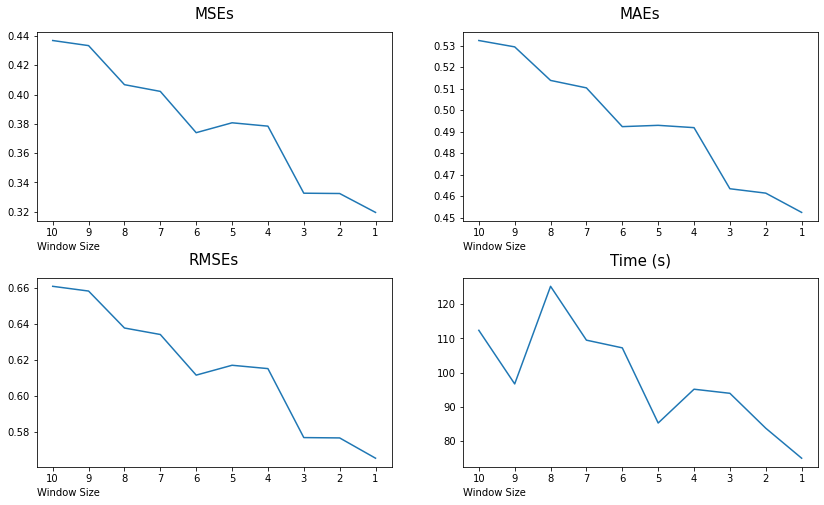

In [14]:
win_sizes_str = [str(n) for n in win_sizes]

fig = plt.figure(figsize=(14,8))
gs = GridSpec(2,2) 

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,1])


ax0.plot(df_err_ws.to_numpy()[0,1:])
ax0.set_xticks(np.arange(10));ax0.set_xticklabels(win_sizes_str)
ax0.set_title("MSEs", {'fontsize': 15}, pad = 13)
ax0.set_xlabel("Window Size", loc="left")
ax1.plot(df_err_ws.to_numpy()[1,1:])
ax1.set_xticks(np.arange(10));ax1.set_xticklabels(win_sizes_str)
ax1.set_title("RMSEs", {'fontsize': 15}, pad = 13)
ax1.set_xlabel("Window Size", loc="left")
ax2.plot(df_err_ws.to_numpy()[2,1:])
ax2.set_xticks(np.arange(10));ax2.set_xticklabels(win_sizes_str)
ax2.set_title("MAEs", {'fontsize': 15}, pad = 13)
ax2.set_xlabel("Window Size", loc="left")
ax3.plot(df_err_ws.to_numpy()[4,1:])
ax3.set_xticks(np.arange(10));ax3.set_xticklabels(win_sizes_str)
ax3.set_title("Time (s)", {'fontsize': 15}, pad = 13)
ax3.set_xlabel("Window Size", loc="left")

gs.update(wspace=0.2, hspace=0.3)

plt.show()

<p style="font-size:18px;"> &emsp; &emsp; &emsp; &emsp; <em>3.2.3. Vanilla, Bidirectional and Stacked</em></p>

V, Bi and S description

In [7]:
# Extract X and y

window_size = 2

def df_to_X_y(df, window_size=window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][748:935].tolist()
    y.append(label)
  return np.array(X), np.array(y)

X1, y1 = df_to_X_y(df)

print('Window size = 2')
print('X shape = ' + str(X1.shape))
print('y shape = ' + str(y1.shape))

Window size = 2
X shape = (363, 2, 937)
y shape = (363, 187)


In [8]:
# Divide into train, validate and test

days = np.shape(X1)[0]
lfw = days-28 # days before the last two weeks
lew = days-56 # days before the last six

X1_train, y1_train = X1[:lew], y1[:lew]
X1_val, y1_val = X1[lew:lfw], y1[lew:lfw]
X1_test, y1_test = X1[lfw:], y1[lfw:]

print('X_train shape = ' + str(X1_train.shape))
print('y_train shape = ' + str(y1_train.shape))
print('X_val shape = ' + str(X1_val.shape))
print('y_val shape = ' + str(y1_val.shape))
print('X_test shape = ' + str(X1_test.shape))
print('y_test shape = ' + str(y1_test.shape))

X_train shape = (307, 2, 937)
y_train shape = (307, 187)
X_val shape = (28, 2, 937)
y_val shape = (28, 187)
X_test shape = (28, 2, 937)
y_test shape = (28, 187)


In [9]:
# Standardization

ssh_training_mean = np.empty(187, dtype=float)
ssh_training_std = np.empty(187, dtype=float)
stress_training_mean = np.empty(187, dtype=float)
stress_training_std = np.empty(187, dtype=float)
east_training_mean = np.empty(187, dtype=float)
east_training_std = np.empty(187, dtype=float)
north_training_mean = np.empty(187, dtype=float)
north_training_std = np.empty(187, dtype=float)
temp_training_mean = np.empty(187, dtype=float)
temp_training_std = np.empty(187, dtype=float)

for i in range(187):
    ssh_training_mean[i] = np.mean(X1_train[:, :, i+4*187])
    ssh_training_std[i] = np.std(X1_train[:, :, i+4*187])
    stress_training_mean[i] = np.mean(X1_train[:, :, i+3*187])
    stress_training_std[i] = np.std(X1_train[:, :, i+3*187])
    east_training_mean[i] = np.mean(X1_train[:, :, i+2*187])
    east_training_std[i] = np.std(X1_train[:, :, i+2*187])
    north_training_mean[i] = np.mean(X1_train[:, :, i+187])
    north_training_std[i] = np.std(X1_train[:, :, i+187])
    temp_training_mean[i] = np.mean(X1_train[:, :, i])
    temp_training_std[i] = np.std(X1_train[:, :, i])

def preprocess(X,y):
  for i in range(187):
    X[:, :, i+4*187] = (X[:, :, i+4*187] - ssh_training_mean[i]) / ssh_training_std[i]
    X[:, :, i+3*187] = (X[:, :, i+3*187] - stress_training_mean[i]) / stress_training_std[i]
    X[:, :, i+2*187] = (X[:, :, i+2*187] - east_training_mean[i]) / east_training_std[i]
    X[:, :, i+187] = (X[:, :, i+187] - north_training_mean[i]) / north_training_std[i]
    X[:, :, i] = (X[:, :, i] - temp_training_mean[i]) / temp_training_std[i]

    y[:, i] = (y[:, i] - ssh_training_mean[i]) / ssh_training_std[i]

preprocess(X1_train, y1_train)
preprocess(X1_val, y1_val)
preprocess(X1_test, y1_test)

**Vanilla LSTM**

In [14]:
vlstm_model = Sequential()
vlstm_model.add(InputLayer((window_size, 937)))
vlstm_model.add(LSTM(640))
vlstm_model.add(Dense(320, 'relu'))
vlstm_model.add(Dense(187, 'linear'))

cp1 = ModelCheckpoint('vlstm_model/', save_best_only=True)
vlstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
vlstm_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp1])
vlstm_model = load_model('vlstm_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8464 - root_mean_squared_error: 0.9200

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 7s 511ms/step - loss: 0.8464 - root_mean_squared_error: 0.9200 - val_loss: 0.3897 - val_root_mean_squared_error: 0.6243
Epoch 2/25
10/10 [==============================] - 0s 49ms/step - loss: 0.5904 - root_mean_squared_error: 0.7683 - val_loss: 0.4663 - val_root_mean_squared_error: 0.6828
Epoch 3/25
10/10 [==============================] - 0s 47ms/step - loss: 0.4312 - root_mean_squared_error: 0.6567 - val_loss: 0.5157 - val_root_mean_squared_error: 0.7181
Epoch 4/25
10/10 [==============================] - 0s 44ms/step - loss: 0.3192 - root_mean_squared_error: 0.5649 - val_loss: 0.5156 - val_root_mean_squared_error: 0.7180
Epoch 5/25
10/10 [==============================] - 0s 47ms/step - loss: 0.2416 - root_mean_squared_error: 0.4915 - val_loss: 0.4769 - val_root_mean_squared_error: 0.6906
Epoch 6/25
10/10 [==============================] - 0s 45ms/step - loss: 0.1917 - root_mean_squared_error: 0.4379 - val_loss: 0.4220 - val_root_mean_square

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 489ms/step - loss: 0.1597 - root_mean_squared_error: 0.3996 - val_loss: 0.3802 - val_root_mean_squared_error: 0.6166
Epoch 8/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.1376 - root_mean_squared_error: 0.3709

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 459ms/step - loss: 0.1368 - root_mean_squared_error: 0.3699 - val_loss: 0.3520 - val_root_mean_squared_error: 0.5933
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1200 - root_mean_squared_error: 0.3464

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 423ms/step - loss: 0.1200 - root_mean_squared_error: 0.3464 - val_loss: 0.3251 - val_root_mean_squared_error: 0.5701
Epoch 10/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.1076 - root_mean_squared_error: 0.3279

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 470ms/step - loss: 0.1070 - root_mean_squared_error: 0.3271 - val_loss: 0.3110 - val_root_mean_squared_error: 0.5577
Epoch 11/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0969 - root_mean_squared_error: 0.3113

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 428ms/step - loss: 0.0962 - root_mean_squared_error: 0.3102 - val_loss: 0.3012 - val_root_mean_squared_error: 0.5488
Epoch 12/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0871 - root_mean_squared_error: 0.2952

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 461ms/step - loss: 0.0872 - root_mean_squared_error: 0.2954 - val_loss: 0.2950 - val_root_mean_squared_error: 0.5431
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0794 - root_mean_squared_error: 0.2818

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 412ms/step - loss: 0.0794 - root_mean_squared_error: 0.2818 - val_loss: 0.2893 - val_root_mean_squared_error: 0.5379
Epoch 14/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0726 - root_mean_squared_error: 0.2695

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 446ms/step - loss: 0.0724 - root_mean_squared_error: 0.2691 - val_loss: 0.2860 - val_root_mean_squared_error: 0.5348
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0664 - root_mean_squared_error: 0.2576

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 424ms/step - loss: 0.0664 - root_mean_squared_error: 0.2576 - val_loss: 0.2821 - val_root_mean_squared_error: 0.5311
Epoch 16/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0607 - root_mean_squared_error: 0.2465

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 402ms/step - loss: 0.0612 - root_mean_squared_error: 0.2474 - val_loss: 0.2769 - val_root_mean_squared_error: 0.5262
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0571 - root_mean_squared_error: 0.2389

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 453ms/step - loss: 0.0571 - root_mean_squared_error: 0.2389 - val_loss: 0.2717 - val_root_mean_squared_error: 0.5212
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0529 - root_mean_squared_error: 0.2299

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 410ms/step - loss: 0.0529 - root_mean_squared_error: 0.2299 - val_loss: 0.2698 - val_root_mean_squared_error: 0.5194
Epoch 19/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0491 - root_mean_squared_error: 0.2216

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 451ms/step - loss: 0.0493 - root_mean_squared_error: 0.2220 - val_loss: 0.2649 - val_root_mean_squared_error: 0.5147
Epoch 20/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0459 - root_mean_squared_error: 0.2142

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 427ms/step - loss: 0.0460 - root_mean_squared_error: 0.2144 - val_loss: 0.2619 - val_root_mean_squared_error: 0.5118
Epoch 21/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0433 - root_mean_squared_error: 0.2081

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 463ms/step - loss: 0.0434 - root_mean_squared_error: 0.2082 - val_loss: 0.2594 - val_root_mean_squared_error: 0.5094
Epoch 22/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0410 - root_mean_squared_error: 0.2025

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 441ms/step - loss: 0.0410 - root_mean_squared_error: 0.2024 - val_loss: 0.2549 - val_root_mean_squared_error: 0.5048
Epoch 23/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0392 - root_mean_squared_error: 0.1979

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 402ms/step - loss: 0.0391 - root_mean_squared_error: 0.1977 - val_loss: 0.2510 - val_root_mean_squared_error: 0.5010
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0368 - root_mean_squared_error: 0.1919

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 439ms/step - loss: 0.0368 - root_mean_squared_error: 0.1919 - val_loss: 0.2481 - val_root_mean_squared_error: 0.4981
Epoch 25/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0347 - root_mean_squared_error: 0.1863

INFO:tensorflow:Assets written to: vlstm_model\assets


INFO:tensorflow:Assets written to: vlstm_model\assets


10/10 [==============================] - 4s 403ms/step - loss: 0.0349 - root_mean_squared_error: 0.1867 - val_loss: 0.2431 - val_root_mean_squared_error: 0.4930


**Bidirectional LSTM**

In [15]:
bilstm_model = Sequential()
bilstm_model.add(InputLayer((window_size, 937)))
bilstm_model.add(Bidirectional(LSTM(640, return_sequences=True)))
bilstm_model.add(Bidirectional(LSTM(640)))
bilstm_model.add(Dense(640, 'relu'))
bilstm_model.add(Dense(320, 'relu'))
bilstm_model.add(Dense(187, 'linear'))

cp2 = ModelCheckpoint('bilstm_model/', save_best_only=True)
bilstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
bilstm_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp2])
bilstm_model = load_model('bilstm_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8881 - root_mean_squared_error: 0.9424

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 27s 3s/step - loss: 0.8881 - root_mean_squared_error: 0.9424 - val_loss: 0.3550 - val_root_mean_squared_error: 0.5958
Epoch 2/25
10/10 [==============================] - 2s 195ms/step - loss: 0.6287 - root_mean_squared_error: 0.7929 - val_loss: 0.4671 - val_root_mean_squared_error: 0.6834
Epoch 3/25
10/10 [==============================] - 2s 206ms/step - loss: 0.4544 - root_mean_squared_error: 0.6741 - val_loss: 0.4370 - val_root_mean_squared_error: 0.6610
Epoch 4/25
10/10 [==============================] - 2s 201ms/step - loss: 0.3307 - root_mean_squared_error: 0.5751 - val_loss: 0.4177 - val_root_mean_squared_error: 0.6463
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.2461 - root_mean_squared_error: 0.4961

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 30s 3s/step - loss: 0.2461 - root_mean_squared_error: 0.4961 - val_loss: 0.3218 - val_root_mean_squared_error: 0.5672
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1833 - root_mean_squared_error: 0.4282

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 17s 2s/step - loss: 0.1833 - root_mean_squared_error: 0.4282 - val_loss: 0.2855 - val_root_mean_squared_error: 0.5344
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1434 - root_mean_squared_error: 0.3787

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 18s 2s/step - loss: 0.1434 - root_mean_squared_error: 0.3787 - val_loss: 0.2679 - val_root_mean_squared_error: 0.5176
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1208 - root_mean_squared_error: 0.3476

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 20s 2s/step - loss: 0.1208 - root_mean_squared_error: 0.3476 - val_loss: 0.2675 - val_root_mean_squared_error: 0.5172
Epoch 9/25
10/10 [==============================] - 3s 292ms/step - loss: 0.1059 - root_mean_squared_error: 0.3254 - val_loss: 0.2685 - val_root_mean_squared_error: 0.5181
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0932 - root_mean_squared_error: 0.3054

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 22s 2s/step - loss: 0.0932 - root_mean_squared_error: 0.3054 - val_loss: 0.2647 - val_root_mean_squared_error: 0.5145
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0828 - root_mean_squared_error: 0.2877

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 22s 2s/step - loss: 0.0828 - root_mean_squared_error: 0.2877 - val_loss: 0.2637 - val_root_mean_squared_error: 0.5135
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0732 - root_mean_squared_error: 0.2706

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0732 - root_mean_squared_error: 0.2706 - val_loss: 0.2634 - val_root_mean_squared_error: 0.5133
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0652 - root_mean_squared_error: 0.2553

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 27s 3s/step - loss: 0.0652 - root_mean_squared_error: 0.2553 - val_loss: 0.2611 - val_root_mean_squared_error: 0.5110
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0580 - root_mean_squared_error: 0.2408

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 23s 3s/step - loss: 0.0580 - root_mean_squared_error: 0.2408 - val_loss: 0.2584 - val_root_mean_squared_error: 0.5084
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0522 - root_mean_squared_error: 0.2284

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0522 - root_mean_squared_error: 0.2284 - val_loss: 0.2546 - val_root_mean_squared_error: 0.5046
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0474 - root_mean_squared_error: 0.2177

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0474 - root_mean_squared_error: 0.2177 - val_loss: 0.2490 - val_root_mean_squared_error: 0.4990
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0433 - root_mean_squared_error: 0.2082

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0433 - root_mean_squared_error: 0.2082 - val_loss: 0.2480 - val_root_mean_squared_error: 0.4980
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0394 - root_mean_squared_error: 0.1986

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 22s 2s/step - loss: 0.0394 - root_mean_squared_error: 0.1986 - val_loss: 0.2452 - val_root_mean_squared_error: 0.4952
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0365 - root_mean_squared_error: 0.1910

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 25s 3s/step - loss: 0.0365 - root_mean_squared_error: 0.1910 - val_loss: 0.2439 - val_root_mean_squared_error: 0.4939
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0335 - root_mean_squared_error: 0.1831

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 20s 2s/step - loss: 0.0335 - root_mean_squared_error: 0.1831 - val_loss: 0.2396 - val_root_mean_squared_error: 0.4895
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0312 - root_mean_squared_error: 0.1767

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0312 - root_mean_squared_error: 0.1767 - val_loss: 0.2338 - val_root_mean_squared_error: 0.4835
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0298 - root_mean_squared_error: 0.1727

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 25s 3s/step - loss: 0.0298 - root_mean_squared_error: 0.1727 - val_loss: 0.2316 - val_root_mean_squared_error: 0.4813
Epoch 23/25
10/10 [==============================] - 5s 484ms/step - loss: 0.0282 - root_mean_squared_error: 0.1679 - val_loss: 0.2320 - val_root_mean_squared_error: 0.4817
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0261 - root_mean_squared_error: 0.1616

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 22s 2s/step - loss: 0.0261 - root_mean_squared_error: 0.1616 - val_loss: 0.2281 - val_root_mean_squared_error: 0.4776
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0244 - root_mean_squared_error: 0.1562

INFO:tensorflow:Assets written to: bilstm_model\assets


INFO:tensorflow:Assets written to: bilstm_model\assets


10/10 [==============================] - 23s 3s/step - loss: 0.0244 - root_mean_squared_error: 0.1562 - val_loss: 0.2238 - val_root_mean_squared_error: 0.4731


**Stacked LSTM**

In [16]:
slstm_model = Sequential()
slstm_model.add(InputLayer((window_size, 937)))
slstm_model.add(LSTM(640, return_sequences=True))
slstm_model.add(LSTM(640))
slstm_model.add(Dense(320, 'relu'))
slstm_model.add(Dense(187, 'linear'))

cp3 = ModelCheckpoint('slstm_model/', save_best_only=True)
slstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
slstm_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp3])
slstm_model = load_model('slstm_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.9214 - root_mean_squared_error: 0.9599

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 13s 1s/step - loss: 0.9214 - root_mean_squared_error: 0.9599 - val_loss: 0.3330 - val_root_mean_squared_error: 0.5770
Epoch 2/25
10/10 [==============================] - 2s 192ms/step - loss: 0.7383 - root_mean_squared_error: 0.8592 - val_loss: 0.4094 - val_root_mean_squared_error: 0.6398
Epoch 3/25
10/10 [==============================] - 2s 187ms/step - loss: 0.5304 - root_mean_squared_error: 0.7283 - val_loss: 0.5369 - val_root_mean_squared_error: 0.7327
Epoch 4/25
10/10 [==============================] - 2s 182ms/step - loss: 0.3869 - root_mean_squared_error: 0.6221 - val_loss: 0.5451 - val_root_mean_squared_error: 0.7383
Epoch 5/25
10/10 [==============================] - 2s 183ms/step - loss: 0.2842 - root_mean_squared_error: 0.5331 - val_loss: 0.4904 - val_root_mean_squared_error: 0.7003
Epoch 6/25
10/10 [==============================] - 2s 181ms/step - loss: 0.2284 - root_mean_squared_error: 0.4779 - val_loss: 0.4067 - val_root_mean_squ

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 8s 836ms/step - loss: 0.1733 - root_mean_squared_error: 0.4163 - val_loss: 0.3044 - val_root_mean_squared_error: 0.5517
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1547 - root_mean_squared_error: 0.3933

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 8s 851ms/step - loss: 0.1547 - root_mean_squared_error: 0.3933 - val_loss: 0.2914 - val_root_mean_squared_error: 0.5398
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.1385 - root_mean_squared_error: 0.3721

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 8s 851ms/step - loss: 0.1385 - root_mean_squared_error: 0.3721 - val_loss: 0.2831 - val_root_mean_squared_error: 0.5321
Epoch 11/25
10/10 [==============================] - 2s 161ms/step - loss: 0.1244 - root_mean_squared_error: 0.3528 - val_loss: 0.2833 - val_root_mean_squared_error: 0.5322
Epoch 12/25
10/10 [==============================] - 2s 159ms/step - loss: 0.1116 - root_mean_squared_error: 0.3341 - val_loss: 0.2845 - val_root_mean_squared_error: 0.5334
Epoch 13/25
10/10 [==============================] - 2s 155ms/step - loss: 0.1008 - root_mean_squared_error: 0.3176 - val_loss: 0.2844 - val_root_mean_squared_error: 0.5333
Epoch 14/25
10/10 [==============================] - 2s 252ms/step - loss: 0.0910 - root_mean_squared_error: 0.3016 - val_loss: 0.2839 - val_root_mean_squared_error: 0.5329
Epoch 15/25
10/10 [==============================] - 2s 187ms/step - loss: 0.0822 - root_mean_squared_error: 0.2867 - val_loss: 0.2849 - val_root_m

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 7s 774ms/step - loss: 0.0685 - root_mean_squared_error: 0.2617 - val_loss: 0.2800 - val_root_mean_squared_error: 0.5292
Epoch 18/25
10/10 [==============================] - 2s 164ms/step - loss: 0.0631 - root_mean_squared_error: 0.2511 - val_loss: 0.2809 - val_root_mean_squared_error: 0.5300
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0587 - root_mean_squared_error: 0.2422

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 8s 820ms/step - loss: 0.0587 - root_mean_squared_error: 0.2422 - val_loss: 0.2788 - val_root_mean_squared_error: 0.5280
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0548 - root_mean_squared_error: 0.2342

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 7s 781ms/step - loss: 0.0548 - root_mean_squared_error: 0.2342 - val_loss: 0.2767 - val_root_mean_squared_error: 0.5260
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0514 - root_mean_squared_error: 0.2268

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 8s 844ms/step - loss: 0.0514 - root_mean_squared_error: 0.2268 - val_loss: 0.2752 - val_root_mean_squared_error: 0.5246
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0483 - root_mean_squared_error: 0.2197

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 7s 780ms/step - loss: 0.0483 - root_mean_squared_error: 0.2197 - val_loss: 0.2718 - val_root_mean_squared_error: 0.5213
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0454 - root_mean_squared_error: 0.2131

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 8s 836ms/step - loss: 0.0454 - root_mean_squared_error: 0.2131 - val_loss: 0.2697 - val_root_mean_squared_error: 0.5193
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0430 - root_mean_squared_error: 0.2073

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 7s 766ms/step - loss: 0.0430 - root_mean_squared_error: 0.2073 - val_loss: 0.2671 - val_root_mean_squared_error: 0.5168
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0409 - root_mean_squared_error: 0.2023

INFO:tensorflow:Assets written to: slstm_model\assets


INFO:tensorflow:Assets written to: slstm_model\assets


10/10 [==============================] - 8s 843ms/step - loss: 0.0409 - root_mean_squared_error: 0.2023 - val_loss: 0.2619 - val_root_mean_squared_error: 0.5117


**Bidirectional & Stacked LSTM**

In [17]:
bislstm_model = Sequential()
bislstm_model.add(InputLayer((window_size, 937)))
bislstm_model.add(Bidirectional(LSTM(640, return_sequences=True)))
bislstm_model.add(Bidirectional(LSTM(640, return_sequences=True)))
bislstm_model.add(LSTM(640, return_sequences=True))
bislstm_model.add(LSTM(640))
bislstm_model.add(Dense(320, 'relu'))
bislstm_model.add(Dense(187, 'linear'))

cp4 = ModelCheckpoint('bislstm_model/', save_best_only=True)
bislstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
bislstm_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp4])
bislstm_model = load_model('bislstm_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.9697 - root_mean_squared_error: 0.9847

INFO:tensorflow:Assets written to: bislstm_model\assets


INFO:tensorflow:Assets written to: bislstm_model\assets


10/10 [==============================] - 41s 4s/step - loss: 0.9697 - root_mean_squared_error: 0.9847 - val_loss: 0.3228 - val_root_mean_squared_error: 0.5682
Epoch 2/25
10/10 [==============================] - 5s 479ms/step - loss: 0.8627 - root_mean_squared_error: 0.9288 - val_loss: 0.3938 - val_root_mean_squared_error: 0.6275
Epoch 3/25
10/10 [==============================] - 5s 468ms/step - loss: 0.6114 - root_mean_squared_error: 0.7819 - val_loss: 0.8566 - val_root_mean_squared_error: 0.9255
Epoch 4/25
10/10 [==============================] - 5s 463ms/step - loss: 0.4445 - root_mean_squared_error: 0.6667 - val_loss: 0.6870 - val_root_mean_squared_error: 0.8288
Epoch 5/25
10/10 [==============================] - 5s 464ms/step - loss: 0.3257 - root_mean_squared_error: 0.5707 - val_loss: 0.3987 - val_root_mean_squared_error: 0.6315
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.2590 - root_mean_squared_error: 0.5089

INFO:tensorflow:Assets written to: bislstm_model\assets


INFO:tensorflow:Assets written to: bislstm_model\assets


10/10 [==============================] - 27s 3s/step - loss: 0.2590 - root_mean_squared_error: 0.5089 - val_loss: 0.2842 - val_root_mean_squared_error: 0.5331
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.2213 - root_mean_squared_error: 0.4704

INFO:tensorflow:Assets written to: bislstm_model\assets


INFO:tensorflow:Assets written to: bislstm_model\assets


10/10 [==============================] - 29s 3s/step - loss: 0.2213 - root_mean_squared_error: 0.4704 - val_loss: 0.2687 - val_root_mean_squared_error: 0.5184
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1982 - root_mean_squared_error: 0.4451

INFO:tensorflow:Assets written to: bislstm_model\assets


INFO:tensorflow:Assets written to: bislstm_model\assets


10/10 [==============================] - 30s 3s/step - loss: 0.1982 - root_mean_squared_error: 0.4451 - val_loss: 0.2662 - val_root_mean_squared_error: 0.5160
Epoch 9/25
10/10 [==============================] - 10s 952ms/step - loss: 0.1857 - root_mean_squared_error: 0.4309 - val_loss: 0.2682 - val_root_mean_squared_error: 0.5178
Epoch 10/25
10/10 [==============================] - 9s 911ms/step - loss: 0.1785 - root_mean_squared_error: 0.4225 - val_loss: 0.2710 - val_root_mean_squared_error: 0.5206
Epoch 11/25
10/10 [==============================] - 9s 924ms/step - loss: 0.1728 - root_mean_squared_error: 0.4157 - val_loss: 0.2718 - val_root_mean_squared_error: 0.5214
Epoch 12/25
10/10 [==============================] - 9s 941ms/step - loss: 0.1665 - root_mean_squared_error: 0.4081 - val_loss: 0.2738 - val_root_mean_squared_error: 0.5232
Epoch 13/25
10/10 [==============================] - 8s 846ms/step - loss: 0.1584 - root_mean_squared_error: 0.3980 - val_loss: 0.2774 - val_root_mea

<p style="font-size:22px;"> &emsp; &emsp; 3.3. GRU</p>

GRU description

**Vanilla GRU**

In [18]:
gru_model = Sequential()
gru_model.add(InputLayer((window_size, 937)))
gru_model.add(GRU(640))
gru_model.add(Dense(320, 'relu'))
gru_model.add(Dense(187, 'linear'))

cp5 = ModelCheckpoint('gru_model/', save_best_only=True)
gru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
gru_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp5])
gru_model = load_model('gru_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8418 - root_mean_squared_error: 0.9175

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 6s 482ms/step - loss: 0.8418 - root_mean_squared_error: 0.9175 - val_loss: 0.4198 - val_root_mean_squared_error: 0.6479
Epoch 2/25
10/10 [==============================] - 1s 119ms/step - loss: 0.5392 - root_mean_squared_error: 0.7343 - val_loss: 0.4843 - val_root_mean_squared_error: 0.6959
Epoch 3/25
10/10 [==============================] - 1s 125ms/step - loss: 0.3824 - root_mean_squared_error: 0.6184 - val_loss: 0.5043 - val_root_mean_squared_error: 0.7101
Epoch 4/25
10/10 [==============================] - 1s 116ms/step - loss: 0.2796 - root_mean_squared_error: 0.5287 - val_loss: 0.4844 - val_root_mean_squared_error: 0.6960
Epoch 5/25
10/10 [==============================] - 1s 120ms/step - loss: 0.2117 - root_mean_squared_error: 0.4601 - val_loss: 0.4433 - val_root_mean_squared_error: 0.6658
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1708 - root_mean_squared_error: 0.4133

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 460ms/step - loss: 0.1708 - root_mean_squared_error: 0.4133 - val_loss: 0.3833 - val_root_mean_squared_error: 0.6191
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1448 - root_mean_squared_error: 0.3805

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 448ms/step - loss: 0.1448 - root_mean_squared_error: 0.3805 - val_loss: 0.3413 - val_root_mean_squared_error: 0.5842
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1276 - root_mean_squared_error: 0.3572

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 5s 543ms/step - loss: 0.1276 - root_mean_squared_error: 0.3572 - val_loss: 0.3089 - val_root_mean_squared_error: 0.5558
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1144 - root_mean_squared_error: 0.3383

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 440ms/step - loss: 0.1144 - root_mean_squared_error: 0.3383 - val_loss: 0.2879 - val_root_mean_squared_error: 0.5366
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.1029 - root_mean_squared_error: 0.3208

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 451ms/step - loss: 0.1029 - root_mean_squared_error: 0.3208 - val_loss: 0.2701 - val_root_mean_squared_error: 0.5197
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0932 - root_mean_squared_error: 0.3053

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 435ms/step - loss: 0.0932 - root_mean_squared_error: 0.3053 - val_loss: 0.2573 - val_root_mean_squared_error: 0.5072
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0848 - root_mean_squared_error: 0.2913

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 440ms/step - loss: 0.0848 - root_mean_squared_error: 0.2913 - val_loss: 0.2482 - val_root_mean_squared_error: 0.4982
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0779 - root_mean_squared_error: 0.2791

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 425ms/step - loss: 0.0779 - root_mean_squared_error: 0.2791 - val_loss: 0.2417 - val_root_mean_squared_error: 0.4916
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0715 - root_mean_squared_error: 0.2674

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 421ms/step - loss: 0.0715 - root_mean_squared_error: 0.2674 - val_loss: 0.2361 - val_root_mean_squared_error: 0.4859
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0661 - root_mean_squared_error: 0.2571

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 5s 549ms/step - loss: 0.0661 - root_mean_squared_error: 0.2571 - val_loss: 0.2318 - val_root_mean_squared_error: 0.4814
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0614 - root_mean_squared_error: 0.2478

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 437ms/step - loss: 0.0614 - root_mean_squared_error: 0.2478 - val_loss: 0.2286 - val_root_mean_squared_error: 0.4781
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0573 - root_mean_squared_error: 0.2394

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 419ms/step - loss: 0.0573 - root_mean_squared_error: 0.2394 - val_loss: 0.2232 - val_root_mean_squared_error: 0.4725
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0537 - root_mean_squared_error: 0.2317

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 463ms/step - loss: 0.0537 - root_mean_squared_error: 0.2317 - val_loss: 0.2216 - val_root_mean_squared_error: 0.4707
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0504 - root_mean_squared_error: 0.2245

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 482ms/step - loss: 0.0504 - root_mean_squared_error: 0.2245 - val_loss: 0.2168 - val_root_mean_squared_error: 0.4656
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0475 - root_mean_squared_error: 0.2180

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 419ms/step - loss: 0.0475 - root_mean_squared_error: 0.2180 - val_loss: 0.2133 - val_root_mean_squared_error: 0.4618
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0450 - root_mean_squared_error: 0.2122

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 455ms/step - loss: 0.0450 - root_mean_squared_error: 0.2122 - val_loss: 0.2110 - val_root_mean_squared_error: 0.4593
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0427 - root_mean_squared_error: 0.2068

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 5s 515ms/step - loss: 0.0427 - root_mean_squared_error: 0.2068 - val_loss: 0.2067 - val_root_mean_squared_error: 0.4547
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0407 - root_mean_squared_error: 0.2017

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 451ms/step - loss: 0.0407 - root_mean_squared_error: 0.2017 - val_loss: 0.2060 - val_root_mean_squared_error: 0.4538
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0388 - root_mean_squared_error: 0.1970

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 445ms/step - loss: 0.0388 - root_mean_squared_error: 0.1970 - val_loss: 0.2000 - val_root_mean_squared_error: 0.4472
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0368 - root_mean_squared_error: 0.1917

INFO:tensorflow:Assets written to: gru_model\assets


INFO:tensorflow:Assets written to: gru_model\assets


10/10 [==============================] - 4s 464ms/step - loss: 0.0368 - root_mean_squared_error: 0.1917 - val_loss: 0.1978 - val_root_mean_squared_error: 0.4448


**Bidirectional GRU**

In [19]:
bigru_model = Sequential()
bigru_model.add(InputLayer((window_size, 937)))
bigru_model.add(Bidirectional(GRU(640, return_sequences=True)))
bigru_model.add(Bidirectional(GRU(640)))
bigru_model.add(Dense(640, 'relu'))
bigru_model.add(Dense(320, 'relu'))
bigru_model.add(Dense(187, 'linear'))

cp6 = ModelCheckpoint('bigru_model/', save_best_only=True)
bigru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
bigru_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp6])
bigru_model = load_model('bigru_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8002 - root_mean_squared_error: 0.8945

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 28s 3s/step - loss: 0.8002 - root_mean_squared_error: 0.8945 - val_loss: 0.4489 - val_root_mean_squared_error: 0.6700
Epoch 2/25
10/10 [==============================] - 5s 549ms/step - loss: 0.5212 - root_mean_squared_error: 0.7220 - val_loss: 0.4828 - val_root_mean_squared_error: 0.6949
Epoch 3/25
10/10 [==============================] - ETA: 0s - loss: 0.3544 - root_mean_squared_error: 0.5953

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 22s 2s/step - loss: 0.3544 - root_mean_squared_error: 0.5953 - val_loss: 0.4000 - val_root_mean_squared_error: 0.6324
Epoch 4/25
10/10 [==============================] - ETA: 0s - loss: 0.2438 - root_mean_squared_error: 0.4937

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 22s 2s/step - loss: 0.2438 - root_mean_squared_error: 0.4937 - val_loss: 0.3152 - val_root_mean_squared_error: 0.5615
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.1708 - root_mean_squared_error: 0.4133

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.1708 - root_mean_squared_error: 0.4133 - val_loss: 0.2743 - val_root_mean_squared_error: 0.5238
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1292 - root_mean_squared_error: 0.3595

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 24s 3s/step - loss: 0.1292 - root_mean_squared_error: 0.3595 - val_loss: 0.2555 - val_root_mean_squared_error: 0.5055
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1064 - root_mean_squared_error: 0.3262

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 22s 2s/step - loss: 0.1064 - root_mean_squared_error: 0.3262 - val_loss: 0.2485 - val_root_mean_squared_error: 0.4985
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.0911 - root_mean_squared_error: 0.3019

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 22s 2s/step - loss: 0.0911 - root_mean_squared_error: 0.3019 - val_loss: 0.2415 - val_root_mean_squared_error: 0.4915
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.0787 - root_mean_squared_error: 0.2805

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0787 - root_mean_squared_error: 0.2805 - val_loss: 0.2390 - val_root_mean_squared_error: 0.4889
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0688 - root_mean_squared_error: 0.2623

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 23s 2s/step - loss: 0.0688 - root_mean_squared_error: 0.2623 - val_loss: 0.2327 - val_root_mean_squared_error: 0.4824
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0610 - root_mean_squared_error: 0.2470

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 22s 2s/step - loss: 0.0610 - root_mean_squared_error: 0.2470 - val_loss: 0.2287 - val_root_mean_squared_error: 0.4782
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0545 - root_mean_squared_error: 0.2336

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0545 - root_mean_squared_error: 0.2336 - val_loss: 0.2235 - val_root_mean_squared_error: 0.4727
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0489 - root_mean_squared_error: 0.2212

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0489 - root_mean_squared_error: 0.2212 - val_loss: 0.2204 - val_root_mean_squared_error: 0.4694
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0446 - root_mean_squared_error: 0.2112

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0446 - root_mean_squared_error: 0.2112 - val_loss: 0.2155 - val_root_mean_squared_error: 0.4642
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0409 - root_mean_squared_error: 0.2023

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0409 - root_mean_squared_error: 0.2023 - val_loss: 0.2107 - val_root_mean_squared_error: 0.4590
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0380 - root_mean_squared_error: 0.1950

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 20s 2s/step - loss: 0.0380 - root_mean_squared_error: 0.1950 - val_loss: 0.2063 - val_root_mean_squared_error: 0.4542
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0356 - root_mean_squared_error: 0.1886

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 28s 3s/step - loss: 0.0356 - root_mean_squared_error: 0.1886 - val_loss: 0.2022 - val_root_mean_squared_error: 0.4496
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0332 - root_mean_squared_error: 0.1822

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 25s 3s/step - loss: 0.0332 - root_mean_squared_error: 0.1822 - val_loss: 0.1977 - val_root_mean_squared_error: 0.4446
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0307 - root_mean_squared_error: 0.1752

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 22s 2s/step - loss: 0.0307 - root_mean_squared_error: 0.1752 - val_loss: 0.1920 - val_root_mean_squared_error: 0.4381
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0287 - root_mean_squared_error: 0.1693

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 23s 3s/step - loss: 0.0287 - root_mean_squared_error: 0.1693 - val_loss: 0.1887 - val_root_mean_squared_error: 0.4344
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0268 - root_mean_squared_error: 0.1637

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0268 - root_mean_squared_error: 0.1637 - val_loss: 0.1852 - val_root_mean_squared_error: 0.4304
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0253 - root_mean_squared_error: 0.1591

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0253 - root_mean_squared_error: 0.1591 - val_loss: 0.1841 - val_root_mean_squared_error: 0.4291
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0238 - root_mean_squared_error: 0.1542

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 19s 2s/step - loss: 0.0238 - root_mean_squared_error: 0.1542 - val_loss: 0.1795 - val_root_mean_squared_error: 0.4237
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0224 - root_mean_squared_error: 0.1496

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0224 - root_mean_squared_error: 0.1496 - val_loss: 0.1773 - val_root_mean_squared_error: 0.4211
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0213 - root_mean_squared_error: 0.1461

INFO:tensorflow:Assets written to: bigru_model\assets


INFO:tensorflow:Assets written to: bigru_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0213 - root_mean_squared_error: 0.1461 - val_loss: 0.1737 - val_root_mean_squared_error: 0.4168


**Stacked GRU**

In [20]:
sgru_model = Sequential()
sgru_model.add(InputLayer((window_size, 937)))
sgru_model.add(GRU(640, return_sequences=True))
sgru_model.add(GRU(640))
sgru_model.add(Dense(320, 'relu'))
sgru_model.add(Dense(187, 'linear'))

cp7 = ModelCheckpoint('sgru_model/', save_best_only=True)
sgru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
sgru_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp7])
sgru_model = load_model('sgru_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8290 - root_mean_squared_error: 0.9105

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 12s 951ms/step - loss: 0.8290 - root_mean_squared_error: 0.9105 - val_loss: 0.3902 - val_root_mean_squared_error: 0.6246
Epoch 2/25
10/10 [==============================] - 2s 238ms/step - loss: 0.5627 - root_mean_squared_error: 0.7501 - val_loss: 0.4969 - val_root_mean_squared_error: 0.7049
Epoch 3/25
10/10 [==============================] - 2s 233ms/step - loss: 0.4030 - root_mean_squared_error: 0.6348 - val_loss: 0.5281 - val_root_mean_squared_error: 0.7267
Epoch 4/25
10/10 [==============================] - 2s 235ms/step - loss: 0.2933 - root_mean_squared_error: 0.5415 - val_loss: 0.4676 - val_root_mean_squared_error: 0.6838
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.2201 - root_mean_squared_error: 0.4692

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 7s 770ms/step - loss: 0.2201 - root_mean_squared_error: 0.4692 - val_loss: 0.3713 - val_root_mean_squared_error: 0.6094
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1753 - root_mean_squared_error: 0.4186

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 7s 769ms/step - loss: 0.1753 - root_mean_squared_error: 0.4186 - val_loss: 0.3003 - val_root_mean_squared_error: 0.5480
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1461 - root_mean_squared_error: 0.3822

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 7s 792ms/step - loss: 0.1461 - root_mean_squared_error: 0.3822 - val_loss: 0.2658 - val_root_mean_squared_error: 0.5156
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1259 - root_mean_squared_error: 0.3549

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 9s 915ms/step - loss: 0.1259 - root_mean_squared_error: 0.3549 - val_loss: 0.2507 - val_root_mean_squared_error: 0.5007
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1107 - root_mean_squared_error: 0.3328

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 7s 775ms/step - loss: 0.1107 - root_mean_squared_error: 0.3328 - val_loss: 0.2416 - val_root_mean_squared_error: 0.4916
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0985 - root_mean_squared_error: 0.3138

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 7s 760ms/step - loss: 0.0985 - root_mean_squared_error: 0.3138 - val_loss: 0.2381 - val_root_mean_squared_error: 0.4879
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0881 - root_mean_squared_error: 0.2968

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 7s 772ms/step - loss: 0.0881 - root_mean_squared_error: 0.2968 - val_loss: 0.2363 - val_root_mean_squared_error: 0.4861
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0793 - root_mean_squared_error: 0.2816

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 7s 778ms/step - loss: 0.0793 - root_mean_squared_error: 0.2816 - val_loss: 0.2303 - val_root_mean_squared_error: 0.4799
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0719 - root_mean_squared_error: 0.2681

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 9s 925ms/step - loss: 0.0719 - root_mean_squared_error: 0.2681 - val_loss: 0.2289 - val_root_mean_squared_error: 0.4784
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0658 - root_mean_squared_error: 0.2564

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 7s 785ms/step - loss: 0.0658 - root_mean_squared_error: 0.2564 - val_loss: 0.2271 - val_root_mean_squared_error: 0.4766
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0608 - root_mean_squared_error: 0.2466

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 7s 779ms/step - loss: 0.0608 - root_mean_squared_error: 0.2466 - val_loss: 0.2239 - val_root_mean_squared_error: 0.4731
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0565 - root_mean_squared_error: 0.2378

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 7s 780ms/step - loss: 0.0565 - root_mean_squared_error: 0.2378 - val_loss: 0.2229 - val_root_mean_squared_error: 0.4721
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0526 - root_mean_squared_error: 0.2293

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 7s 772ms/step - loss: 0.0526 - root_mean_squared_error: 0.2293 - val_loss: 0.2201 - val_root_mean_squared_error: 0.4691
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0493 - root_mean_squared_error: 0.2221

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 8s 917ms/step - loss: 0.0493 - root_mean_squared_error: 0.2221 - val_loss: 0.2180 - val_root_mean_squared_error: 0.4669
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0466 - root_mean_squared_error: 0.2159

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 7s 793ms/step - loss: 0.0466 - root_mean_squared_error: 0.2159 - val_loss: 0.2143 - val_root_mean_squared_error: 0.4629
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0439 - root_mean_squared_error: 0.2095

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 7s 764ms/step - loss: 0.0439 - root_mean_squared_error: 0.2095 - val_loss: 0.2132 - val_root_mean_squared_error: 0.4617
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0417 - root_mean_squared_error: 0.2042

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 8s 860ms/step - loss: 0.0417 - root_mean_squared_error: 0.2042 - val_loss: 0.2078 - val_root_mean_squared_error: 0.4559
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0395 - root_mean_squared_error: 0.1989

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 9s 932ms/step - loss: 0.0395 - root_mean_squared_error: 0.1989 - val_loss: 0.2067 - val_root_mean_squared_error: 0.4546
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0375 - root_mean_squared_error: 0.1935

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 8s 894ms/step - loss: 0.0375 - root_mean_squared_error: 0.1935 - val_loss: 0.2031 - val_root_mean_squared_error: 0.4507
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0360 - root_mean_squared_error: 0.1898

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 8s 829ms/step - loss: 0.0360 - root_mean_squared_error: 0.1898 - val_loss: 0.1984 - val_root_mean_squared_error: 0.4454
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0343 - root_mean_squared_error: 0.1851

INFO:tensorflow:Assets written to: sgru_model\assets


INFO:tensorflow:Assets written to: sgru_model\assets


10/10 [==============================] - 8s 819ms/step - loss: 0.0343 - root_mean_squared_error: 0.1851 - val_loss: 0.1948 - val_root_mean_squared_error: 0.4414


**Bidirectional & Stacked GRU**

In [21]:
bisgru_model = Sequential()
bisgru_model.add(InputLayer((window_size, 937)))
bisgru_model.add(Bidirectional(GRU(640, return_sequences=True)))
bisgru_model.add(Bidirectional(GRU(640, return_sequences=True)))
bisgru_model.add(GRU(640, return_sequences=True))
bisgru_model.add(GRU(640))
bisgru_model.add(Dense(320, 'relu'))
bisgru_model.add(Dense(187, 'linear'))

cp8 = ModelCheckpoint('bisgru_model/', save_best_only=True)
bisgru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
bisgru_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp8])
bisgru_model = load_model('bisgru_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8535 - root_mean_squared_error: 0.9238

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 39s 3s/step - loss: 0.8535 - root_mean_squared_error: 0.9238 - val_loss: 0.4478 - val_root_mean_squared_error: 0.6692
Epoch 2/25
10/10 [==============================] - 9s 899ms/step - loss: 0.5604 - root_mean_squared_error: 0.7486 - val_loss: 0.7243 - val_root_mean_squared_error: 0.8510
Epoch 3/25
10/10 [==============================] - 9s 893ms/step - loss: 0.3939 - root_mean_squared_error: 0.6276 - val_loss: 0.5015 - val_root_mean_squared_error: 0.7082
Epoch 4/25
10/10 [==============================] - ETA: 0s - loss: 0.2898 - root_mean_squared_error: 0.5383

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 29s 3s/step - loss: 0.2898 - root_mean_squared_error: 0.5383 - val_loss: 0.2810 - val_root_mean_squared_error: 0.5301
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.2224 - root_mean_squared_error: 0.4716

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 29s 3s/step - loss: 0.2224 - root_mean_squared_error: 0.4716 - val_loss: 0.2549 - val_root_mean_squared_error: 0.5049
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1738 - root_mean_squared_error: 0.4169

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 29s 3s/step - loss: 0.1738 - root_mean_squared_error: 0.4169 - val_loss: 0.2481 - val_root_mean_squared_error: 0.4981
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1422 - root_mean_squared_error: 0.3771

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 29s 3s/step - loss: 0.1422 - root_mean_squared_error: 0.3771 - val_loss: 0.2445 - val_root_mean_squared_error: 0.4944
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1224 - root_mean_squared_error: 0.3499

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 30s 3s/step - loss: 0.1224 - root_mean_squared_error: 0.3499 - val_loss: 0.2421 - val_root_mean_squared_error: 0.4921
Epoch 9/25
10/10 [==============================] - 9s 919ms/step - loss: 0.1067 - root_mean_squared_error: 0.3266 - val_loss: 0.2435 - val_root_mean_squared_error: 0.4934
Epoch 10/25
10/10 [==============================] - 9s 915ms/step - loss: 0.0942 - root_mean_squared_error: 0.3069 - val_loss: 0.2472 - val_root_mean_squared_error: 0.4972
Epoch 11/25
10/10 [==============================] - 9s 906ms/step - loss: 0.0843 - root_mean_squared_error: 0.2903 - val_loss: 0.2498 - val_root_mean_squared_error: 0.4998
Epoch 12/25
10/10 [==============================] - 9s 917ms/step - loss: 0.0762 - root_mean_squared_error: 0.2760 - val_loss: 0.2476 - val_root_mean_squared_error: 0.4976
Epoch 13/25
10/10 [==============================] - 9s 916ms/step - loss: 0.0691 - root_mean_squared_error: 0.2629 - val_loss: 0.2448 - val_root_mean

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0596 - root_mean_squared_error: 0.2441 - val_loss: 0.2361 - val_root_mean_squared_error: 0.4859
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0552 - root_mean_squared_error: 0.2349

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 28s 3s/step - loss: 0.0552 - root_mean_squared_error: 0.2349 - val_loss: 0.2315 - val_root_mean_squared_error: 0.4812
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0516 - root_mean_squared_error: 0.2271

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 30s 3s/step - loss: 0.0516 - root_mean_squared_error: 0.2271 - val_loss: 0.2265 - val_root_mean_squared_error: 0.4760
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0482 - root_mean_squared_error: 0.2196

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0482 - root_mean_squared_error: 0.2196 - val_loss: 0.2215 - val_root_mean_squared_error: 0.4707
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0472 - root_mean_squared_error: 0.2172

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0472 - root_mean_squared_error: 0.2172 - val_loss: 0.2153 - val_root_mean_squared_error: 0.4640
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0450 - root_mean_squared_error: 0.2122

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0450 - root_mean_squared_error: 0.2122 - val_loss: 0.2128 - val_root_mean_squared_error: 0.4613
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0414 - root_mean_squared_error: 0.2035

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 30s 3s/step - loss: 0.0414 - root_mean_squared_error: 0.2035 - val_loss: 0.2080 - val_root_mean_squared_error: 0.4560
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0384 - root_mean_squared_error: 0.1960

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0384 - root_mean_squared_error: 0.1960 - val_loss: 0.2048 - val_root_mean_squared_error: 0.4525
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0363 - root_mean_squared_error: 0.1906

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 28s 3s/step - loss: 0.0363 - root_mean_squared_error: 0.1906 - val_loss: 0.1971 - val_root_mean_squared_error: 0.4439
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0343 - root_mean_squared_error: 0.1853

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 30s 3s/step - loss: 0.0343 - root_mean_squared_error: 0.1853 - val_loss: 0.1945 - val_root_mean_squared_error: 0.4410
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0324 - root_mean_squared_error: 0.1799

INFO:tensorflow:Assets written to: bisgru_model\assets


INFO:tensorflow:Assets written to: bisgru_model\assets


10/10 [==============================] - 29s 3s/step - loss: 0.0324 - root_mean_squared_error: 0.1799 - val_loss: 0.1903 - val_root_mean_squared_error: 0.4362


<p style="font-size:22px;"> &emsp; &emsp; 3.4. 1-Dimensional CNN</p>

1D CNN description

**Kernel Size = 2**

In [22]:
# Window Size = 4

window_size2 = 4

def df_to_X_y(df, window_size=window_size2):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][748:935].tolist()
    y.append(label)
  return np.array(X), np.array(y)

X2, y2 = df_to_X_y(df)
print('X shape = ' + str(X2.shape) + ' and y shape = ' + str(y2.shape))

# Divide into train, validate and test
days = np.shape(X2)[0]
lfw = days-28 # days before the last two weeks
lew = days-56 # days before the last six

X2_train, y2_train = X2[:lew], y2[:lew]
X2_val, y2_val = X2[lew:lfw], y2[lew:lfw]
X2_test, y2_test = X2[lfw:], y2[lfw:]

print('X_train shape = ' + str(X2_train.shape))
print('y_train shape = ' + str(y2_train.shape))
print('X_val shape = ' + str(X2_val.shape))
print('y_val shape = ' + str(y2_val.shape))
print('X_test shape = ' + str(X2_test.shape))
print('y_test shape = ' + str(y2_test.shape))

# Standardization

ssh_training_mean = np.empty(187, dtype=float)
ssh_training_std = np.empty(187, dtype=float)
stress_training_mean = np.empty(187, dtype=float)
stress_training_std = np.empty(187, dtype=float)
east_training_mean = np.empty(187, dtype=float)
east_training_std = np.empty(187, dtype=float)
north_training_mean = np.empty(187, dtype=float)
north_training_std = np.empty(187, dtype=float)
temp_training_mean = np.empty(187, dtype=float)
temp_training_std = np.empty(187, dtype=float)

for i in range(187):
    ssh_training_mean[i] = np.mean(X2_train[:, :, i+4*187])
    ssh_training_std[i] = np.std(X2_train[:, :, i+4*187])
    stress_training_mean[i] = np.mean(X2_train[:, :, i+3*187])
    stress_training_std[i] = np.std(X2_train[:, :, i+3*187])
    east_training_mean[i] = np.mean(X2_train[:, :, i+2*187])
    east_training_std[i] = np.std(X2_train[:, :, i+2*187])
    north_training_mean[i] = np.mean(X2_train[:, :, i+187])
    north_training_std[i] = np.std(X2_train[:, :, i+187])
    temp_training_mean[i] = np.mean(X2_train[:, :, i])
    temp_training_std[i] = np.std(X2_train[:, :, i])

def preprocess(X,y):
  for i in range(187):
    X[:, :, i+4*187] = (X[:, :, i+4*187] - ssh_training_mean[i]) / ssh_training_std[i]
    X[:, :, i+3*187] = (X[:, :, i+3*187] - stress_training_mean[i]) / stress_training_std[i]
    X[:, :, i+2*187] = (X[:, :, i+2*187] - east_training_mean[i]) / east_training_std[i]
    X[:, :, i+187] = (X[:, :, i+187] - north_training_mean[i]) / north_training_std[i]
    X[:, :, i] = (X[:, :, i] - temp_training_mean[i]) / temp_training_std[i]

    y[:, i] = (y[:, i] - ssh_training_mean[i]) / ssh_training_std[i]

preprocess(X2_train, y2_train)
preprocess(X2_val, y2_val)
preprocess(X2_test, y2_test)

X shape = (361, 4, 937) and y shape = (361, 187)
X_train shape = (305, 4, 937)
y_train shape = (305, 187)
X_val shape = (28, 4, 937)
y_val shape = (28, 187)
X_test shape = (28, 4, 937)
y_test shape = (28, 187)


In [23]:
cnn_k2_model = Sequential()
cnn_k2_model.add(InputLayer((window_size2, 937)))
cnn_k2_model.add(Conv1D(640, kernel_size=2, activation='relu'))
cnn_k2_model.add(Flatten())
cnn_k2_model.add(Dense(640, 'relu'))
cnn_k2_model.add(Dense(320, 'relu'))
cnn_k2_model.add(Dense(187, 'linear'))

cp9 = ModelCheckpoint('cnn_k2_model/', save_best_only=True)
cnn_k2_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
cnn_k2_model.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=25, callbacks=[cp9])
cnn_k2_model = load_model('cnn_k2_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8916 - root_mean_squared_error: 0.9442INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 158ms/step - loss: 0.8916 - root_mean_squared_error: 0.9442 - val_loss: 0.4182 - val_root_mean_squared_error: 0.6467
Epoch 2/25
10/10 [==============================] - 1s 77ms/step - loss: 0.5542 - root_mean_squared_error: 0.7444 - val_loss: 0.4281 - val_root_mean_squared_error: 0.6543
Epoch 3/25
10/10 [==============================] - 1s 83ms/step - loss: 0.3982 - root_mean_squared_error: 0.6310 - val_loss: 0.4185 - val_root_mean_squared_error: 0.6469
Epoch 4/25
10/10 [==============================] - ETA: 0s - loss: 0.2882 - root_mean_squared_error: 0.5368INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 3s 312ms/step - loss: 0.2882 - root_mean_squared_error: 0.5368 - val_loss: 0.4055 - val_root_mean_squared_error: 0.6368
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.2108 - root_mean_squared_error: 0.4591INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 1s 149ms/step - loss: 0.2108 - root_mean_squared_error: 0.4591 - val_loss: 0.3887 - val_root_mean_squared_error: 0.6234
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1636 - root_mean_squared_error: 0.4044INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 1s 145ms/step - loss: 0.1636 - root_mean_squared_error: 0.4044 - val_loss: 0.3676 - val_root_mean_squared_error: 0.6063
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1369 - root_mean_squared_error: 0.3700INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 1s 147ms/step - loss: 0.1369 - root_mean_squared_error: 0.3700 - val_loss: 0.3498 - val_root_mean_squared_error: 0.5915
Epoch 8/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.1201 - root_mean_squared_error: 0.3466INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 1s 150ms/step - loss: 0.1199 - root_mean_squared_error: 0.3462 - val_loss: 0.3365 - val_root_mean_squared_error: 0.5801
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1064 - root_mean_squared_error: 0.3263INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 1s 146ms/step - loss: 0.1064 - root_mean_squared_error: 0.3263 - val_loss: 0.3247 - val_root_mean_squared_error: 0.5699
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0955 - root_mean_squared_error: 0.3091INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 1s 147ms/step - loss: 0.0955 - root_mean_squared_error: 0.3091 - val_loss: 0.3194 - val_root_mean_squared_error: 0.5652
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0860 - root_mean_squared_error: 0.2932INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 1s 151ms/step - loss: 0.0860 - root_mean_squared_error: 0.2932 - val_loss: 0.3106 - val_root_mean_squared_error: 0.5573
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0779 - root_mean_squared_error: 0.2792INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 1s 145ms/step - loss: 0.0779 - root_mean_squared_error: 0.2792 - val_loss: 0.3025 - val_root_mean_squared_error: 0.5500
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0701 - root_mean_squared_error: 0.2648INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 1s 147ms/step - loss: 0.0701 - root_mean_squared_error: 0.2648 - val_loss: 0.2991 - val_root_mean_squared_error: 0.5469
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0642 - root_mean_squared_error: 0.2534INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 1s 151ms/step - loss: 0.0642 - root_mean_squared_error: 0.2534 - val_loss: 0.2941 - val_root_mean_squared_error: 0.5423
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0583 - root_mean_squared_error: 0.2415INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 182ms/step - loss: 0.0583 - root_mean_squared_error: 0.2415 - val_loss: 0.2880 - val_root_mean_squared_error: 0.5367
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0537 - root_mean_squared_error: 0.2317INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 2s 162ms/step - loss: 0.0537 - root_mean_squared_error: 0.2317 - val_loss: 0.2879 - val_root_mean_squared_error: 0.5365
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0495 - root_mean_squared_error: 0.2224INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 1s 147ms/step - loss: 0.0495 - root_mean_squared_error: 0.2224 - val_loss: 0.2840 - val_root_mean_squared_error: 0.5329
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0464 - root_mean_squared_error: 0.2153INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 1s 148ms/step - loss: 0.0464 - root_mean_squared_error: 0.2153 - val_loss: 0.2829 - val_root_mean_squared_error: 0.5318
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0436 - root_mean_squared_error: 0.2089INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 1s 149ms/step - loss: 0.0436 - root_mean_squared_error: 0.2089 - val_loss: 0.2784 - val_root_mean_squared_error: 0.5276
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0409 - root_mean_squared_error: 0.2021INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 1s 146ms/step - loss: 0.0409 - root_mean_squared_error: 0.2021 - val_loss: 0.2739 - val_root_mean_squared_error: 0.5234
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0384 - root_mean_squared_error: 0.1958INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 1s 147ms/step - loss: 0.0384 - root_mean_squared_error: 0.1958 - val_loss: 0.2703 - val_root_mean_squared_error: 0.5199
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0362 - root_mean_squared_error: 0.1902INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 1s 150ms/step - loss: 0.0362 - root_mean_squared_error: 0.1902 - val_loss: 0.2658 - val_root_mean_squared_error: 0.5156
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0344 - root_mean_squared_error: 0.1856INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 1s 152ms/step - loss: 0.0344 - root_mean_squared_error: 0.1856 - val_loss: 0.2641 - val_root_mean_squared_error: 0.5139
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0324 - root_mean_squared_error: 0.1800INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 1s 145ms/step - loss: 0.0324 - root_mean_squared_error: 0.1800 - val_loss: 0.2593 - val_root_mean_squared_error: 0.5092
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0309 - root_mean_squared_error: 0.1758INFO:tensorflow:Assets written to: cnn_k2_model\assets


INFO:tensorflow:Assets written to: cnn_k2_model\assets


10/10 [==============================] - 1s 148ms/step - loss: 0.0309 - root_mean_squared_error: 0.1758 - val_loss: 0.2567 - val_root_mean_squared_error: 0.5066


**Kernel Size = 4**

In [24]:
# Window Size = 6

window_size3 = 6

def df_to_X_y(df, window_size=window_size3):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][748:935].tolist()
    y.append(label)
  return np.array(X), np.array(y)

X3, y3 = df_to_X_y(df)
print('X shape = ' + str(X3.shape) + ' and y shape = ' + str(y3.shape))

# Divide into train, validate and test
days = np.shape(X3)[0]
lfw = days-28 # days before the last two weeks
lew = days-56 # days before the last six

X3_train, y3_train = X3[:lew], y3[:lew]
X3_val, y3_val = X3[lew:lfw], y3[lew:lfw]
X3_test, y3_test = X3[lfw:], y3[lfw:]

print('X_train shape = ' + str(X3_train.shape))
print('y_train shape = ' + str(y3_train.shape))
print('X_val shape = ' + str(X3_val.shape))
print('y_val shape = ' + str(y3_val.shape))
print('X_test shape = ' + str(X3_test.shape))
print('y_test shape = ' + str(y3_test.shape))

# Standardization

ssh_training_mean = np.empty(187, dtype=float)
ssh_training_std = np.empty(187, dtype=float)
stress_training_mean = np.empty(187, dtype=float)
stress_training_std = np.empty(187, dtype=float)
east_training_mean = np.empty(187, dtype=float)
east_training_std = np.empty(187, dtype=float)
north_training_mean = np.empty(187, dtype=float)
north_training_std = np.empty(187, dtype=float)
temp_training_mean = np.empty(187, dtype=float)
temp_training_std = np.empty(187, dtype=float)

for i in range(187):
    ssh_training_mean[i] = np.mean(X3_train[:, :, i+4*187])
    ssh_training_std[i] = np.std(X3_train[:, :, i+4*187])
    stress_training_mean[i] = np.mean(X3_train[:, :, i+3*187])
    stress_training_std[i] = np.std(X3_train[:, :, i+3*187])
    east_training_mean[i] = np.mean(X3_train[:, :, i+2*187])
    east_training_std[i] = np.std(X3_train[:, :, i+2*187])
    north_training_mean[i] = np.mean(X3_train[:, :, i+187])
    north_training_std[i] = np.std(X3_train[:, :, i+187])
    temp_training_mean[i] = np.mean(X3_train[:, :, i])
    temp_training_std[i] = np.std(X3_train[:, :, i])

def preprocess(X,y):
  for i in range(187):
    X[:, :, i+4*187] = (X[:, :, i+4*187] - ssh_training_mean[i]) / ssh_training_std[i]
    X[:, :, i+3*187] = (X[:, :, i+3*187] - stress_training_mean[i]) / stress_training_std[i]
    X[:, :, i+2*187] = (X[:, :, i+2*187] - east_training_mean[i]) / east_training_std[i]
    X[:, :, i+187] = (X[:, :, i+187] - north_training_mean[i]) / north_training_std[i]
    X[:, :, i] = (X[:, :, i] - temp_training_mean[i]) / temp_training_std[i]

    y[:, i] = (y[:, i] - ssh_training_mean[i]) / ssh_training_std[i]

preprocess(X3_train, y3_train)
preprocess(X3_val, y3_val)
preprocess(X3_test, y3_test)

X shape = (359, 6, 937) and y shape = (359, 187)
X_train shape = (303, 6, 937)
y_train shape = (303, 187)
X_val shape = (28, 6, 937)
y_val shape = (28, 187)
X_test shape = (28, 6, 937)
y_test shape = (28, 187)


In [25]:
cnn_k4_model = Sequential()
cnn_k4_model.add(InputLayer((window_size3, 937)))
cnn_k4_model.add(Conv1D(640, kernel_size=4, activation='relu'))
cnn_k4_model.add(Flatten())
cnn_k4_model.add(Dense(640, 'relu'))
cnn_k4_model.add(Dense(320, 'relu'))
cnn_k4_model.add(Dense(187, 'linear'))

cp10 = ModelCheckpoint('cnn_k4_model/', save_best_only=True)
cnn_k4_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
cnn_k4_model.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=25, callbacks=[cp10])
cnn_k4_model = load_model('cnn_k4_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8439 - root_mean_squared_error: 0.9186INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 204ms/step - loss: 0.8439 - root_mean_squared_error: 0.9186 - val_loss: 0.4445 - val_root_mean_squared_error: 0.6667
Epoch 2/25
10/10 [==============================] - ETA: 0s - loss: 0.5049 - root_mean_squared_error: 0.7106INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 194ms/step - loss: 0.5049 - root_mean_squared_error: 0.7106 - val_loss: 0.4335 - val_root_mean_squared_error: 0.6584
Epoch 3/25
10/10 [==============================] - 1s 119ms/step - loss: 0.3404 - root_mean_squared_error: 0.5834 - val_loss: 0.4352 - val_root_mean_squared_error: 0.6597
Epoch 4/25
10/10 [==============================] - ETA: 0s - loss: 0.2348 - root_mean_squared_error: 0.4846INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 195ms/step - loss: 0.2348 - root_mean_squared_error: 0.4846 - val_loss: 0.4219 - val_root_mean_squared_error: 0.6496
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.1718 - root_mean_squared_error: 0.4145INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 295ms/step - loss: 0.1718 - root_mean_squared_error: 0.4145 - val_loss: 0.4022 - val_root_mean_squared_error: 0.6342
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1377 - root_mean_squared_error: 0.3711INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 3s 348ms/step - loss: 0.1377 - root_mean_squared_error: 0.3711 - val_loss: 0.3884 - val_root_mean_squared_error: 0.6232
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1178 - root_mean_squared_error: 0.3433INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 235ms/step - loss: 0.1178 - root_mean_squared_error: 0.3433 - val_loss: 0.3775 - val_root_mean_squared_error: 0.6144
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1031 - root_mean_squared_error: 0.3210INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 244ms/step - loss: 0.1031 - root_mean_squared_error: 0.3210 - val_loss: 0.3588 - val_root_mean_squared_error: 0.5990
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.0912 - root_mean_squared_error: 0.3019INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 222ms/step - loss: 0.0912 - root_mean_squared_error: 0.3019 - val_loss: 0.3481 - val_root_mean_squared_error: 0.5900
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0812 - root_mean_squared_error: 0.2850INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 224ms/step - loss: 0.0812 - root_mean_squared_error: 0.2850 - val_loss: 0.3406 - val_root_mean_squared_error: 0.5836
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0731 - root_mean_squared_error: 0.2704INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 226ms/step - loss: 0.0731 - root_mean_squared_error: 0.2704 - val_loss: 0.3338 - val_root_mean_squared_error: 0.5777
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0667 - root_mean_squared_error: 0.2583INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 207ms/step - loss: 0.0667 - root_mean_squared_error: 0.2583 - val_loss: 0.3282 - val_root_mean_squared_error: 0.5729
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0614 - root_mean_squared_error: 0.2477INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 203ms/step - loss: 0.0614 - root_mean_squared_error: 0.2477 - val_loss: 0.3192 - val_root_mean_squared_error: 0.5650
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0569 - root_mean_squared_error: 0.2384INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 202ms/step - loss: 0.0569 - root_mean_squared_error: 0.2384 - val_loss: 0.3161 - val_root_mean_squared_error: 0.5622
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0530 - root_mean_squared_error: 0.2301INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 206ms/step - loss: 0.0530 - root_mean_squared_error: 0.2301 - val_loss: 0.3081 - val_root_mean_squared_error: 0.5551
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0495 - root_mean_squared_error: 0.2226INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 203ms/step - loss: 0.0495 - root_mean_squared_error: 0.2226 - val_loss: 0.3060 - val_root_mean_squared_error: 0.5532
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0458 - root_mean_squared_error: 0.2139INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 204ms/step - loss: 0.0458 - root_mean_squared_error: 0.2139 - val_loss: 0.3034 - val_root_mean_squared_error: 0.5508
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0429 - root_mean_squared_error: 0.2071INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 202ms/step - loss: 0.0429 - root_mean_squared_error: 0.2071 - val_loss: 0.2968 - val_root_mean_squared_error: 0.5448
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0408 - root_mean_squared_error: 0.2019INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 209ms/step - loss: 0.0408 - root_mean_squared_error: 0.2019 - val_loss: 0.2943 - val_root_mean_squared_error: 0.5425
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0382 - root_mean_squared_error: 0.1955INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 202ms/step - loss: 0.0382 - root_mean_squared_error: 0.1955 - val_loss: 0.2916 - val_root_mean_squared_error: 0.5400
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0361 - root_mean_squared_error: 0.1901INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 208ms/step - loss: 0.0361 - root_mean_squared_error: 0.1901 - val_loss: 0.2884 - val_root_mean_squared_error: 0.5370
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0341 - root_mean_squared_error: 0.1847INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 204ms/step - loss: 0.0341 - root_mean_squared_error: 0.1847 - val_loss: 0.2858 - val_root_mean_squared_error: 0.5346
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0326 - root_mean_squared_error: 0.1805INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 207ms/step - loss: 0.0326 - root_mean_squared_error: 0.1805 - val_loss: 0.2815 - val_root_mean_squared_error: 0.5306
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0306 - root_mean_squared_error: 0.1748INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 202ms/step - loss: 0.0306 - root_mean_squared_error: 0.1748 - val_loss: 0.2770 - val_root_mean_squared_error: 0.5263
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0291 - root_mean_squared_error: 0.1705INFO:tensorflow:Assets written to: cnn_k4_model\assets


INFO:tensorflow:Assets written to: cnn_k4_model\assets


10/10 [==============================] - 2s 208ms/step - loss: 0.0291 - root_mean_squared_error: 0.1705 - val_loss: 0.2748 - val_root_mean_squared_error: 0.5243


<p style="font-size:22px;"> &emsp; &emsp; 3.5. Evaluating and Comparing Performance</p>

In [26]:
models = [vlstm_model, bilstm_model, slstm_model, bislstm_model, 
          gru_model, bigru_model, sgru_model, bisgru_model]
MSEs = []
RMSEs = []
MAEs = []

for i in models:
    predictions = i.predict(X1_test).flatten()
    MSEs.append(mse(y1_test.flatten(), predictions))
    RMSEs.append(np.sqrt(mse(y1_test.flatten(), predictions)))
    MAEs.append(mae(y1_test.flatten(), predictions))

pred_cnn_k2 = cnn_k2_model.predict(X2_test).flatten()
MSEs.append(mse(y2_test.flatten(), pred_cnn_k2))
RMSEs.append(np.sqrt(mse(y2_test.flatten(), pred_cnn_k2)))
MAEs.append(mae(y2_test.flatten(), pred_cnn_k2))

pred_cnn_k4 = cnn_k4_model.predict(X3_test).flatten()
MSEs.append(mse(y3_test.flatten(), pred_cnn_k4))
RMSEs.append(np.sqrt(mse(y3_test.flatten(), pred_cnn_k4)))
MAEs.append(mae(y3_test.flatten(), pred_cnn_k4))


col_names = ['V LSTM', 'Bi LSTM', 'St LSTM', 'Bi+St LSTM', 
             'V GRU', 'Bi GRU', 'St GRU', 'Bi+St GRU', 
             '1D CNN (Ker 2)', '1D CNN (Ker 4)']

performance_df = pd.DataFrame()
performance_df['KPIs'] = ['MSE', 'RMSE', 'MAE']

for i in range(len(col_names)):
    performance_df[col_names[i]] = [MSEs[i], RMSEs[i], MAEs[i]]

In [27]:
performance_df

,KPIs,V LSTM,Bi LSTM,St LSTM,Bi+St LSTM,V GRU,Bi GRU,St GRU,Bi+St GRU,1D CNN (Ker 2),1D CNN (Ker 4)
0,MSE,0.316333,0.299651,0.327608,0.334961,0.305712,0.260143,0.279612,0.272027,0.357951,0.404248
1,RMSE,0.562435,0.547404,0.572371,0.578758,0.552913,0.510042,0.528783,0.521562,0.598290,0.635805
2,MAE,0.449450,0.439782,0.460038,0.468739,0.441562,0.408743,0.425910,0.419899,0.476357,0.507574


MSE =  0.29965121333801203
RMSE =  0.5474040677032023
MAE =  0.4397816815209247


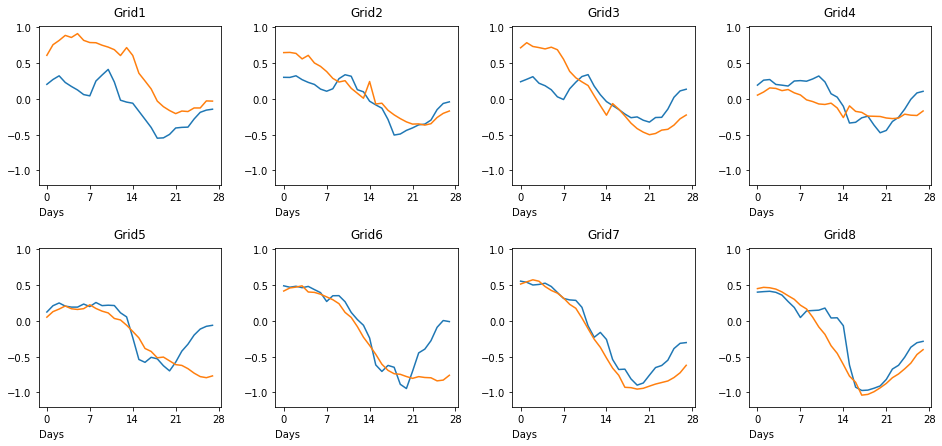

In [28]:
# Best performing LSTM variant (Bidirectional)
plot_predictions(bilstm_model, X1_test, y1_test)

MSE =  0.26014302581948767
RMSE =  0.5100421804316655
MAE =  0.4087433914900716


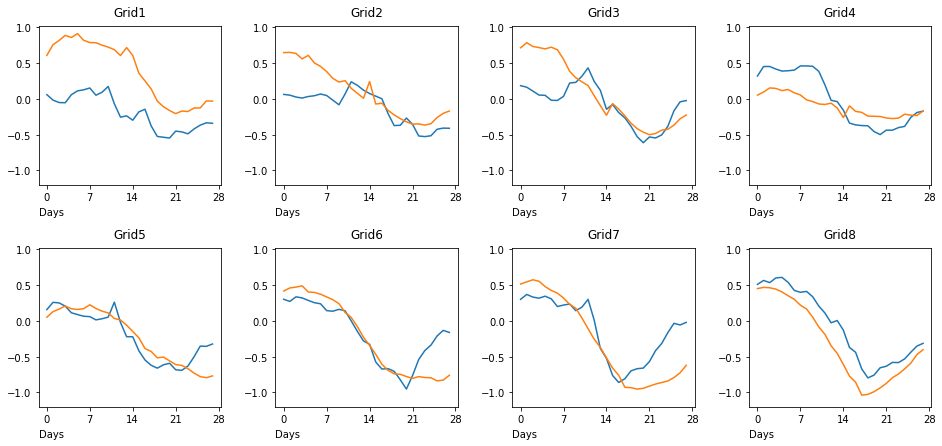

In [29]:
# Best performing GRU variant (Bidirectional + Stacked)
plot_predictions(bigru_model, X1_test, y1_test)

MSE =  0.357950550538173
RMSE =  0.5982896878086509
MAE =  0.4763574165213637


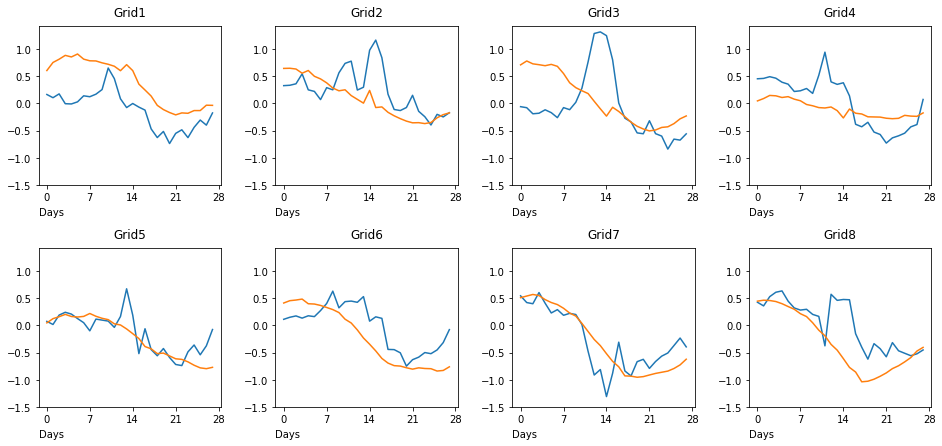

In [30]:
# Best performing CNN variant (Kernel Size = 2)
plot_predictions(cnn_k2_model, X2_test, y2_test)

<p style="font-size:22px;"> &emsp; &emsp; 3.6. Attention Mechanism</p>

Attention Mechanism description

In [31]:
# Attention layer

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [32]:
bilstm_att_model = Sequential()
bilstm_att_model.add(InputLayer((window_size, 937)))
bilstm_att_model.add(Bidirectional(LSTM(640, return_sequences=True)))
bilstm_att_model.add(Bidirectional(LSTM(640, return_sequences=True)))
bilstm_att_model.add(attention())
bilstm_att_model.add(Dense(640, 'relu'))
bilstm_att_model.add(Dense(320, 'relu'))
bilstm_att_model.add(Dense(187, 'linear'))

cp11 = ModelCheckpoint('bilstm_att_model/', save_best_only=True)
bilstm_att_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
bilstm_att_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp11])
bilstm_att_model = load_model('bilstm_att_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8875 - root_mean_squared_error: 0.9421

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 31s 3s/step - loss: 0.8875 - root_mean_squared_error: 0.9421 - val_loss: 0.3570 - val_root_mean_squared_error: 0.5975
Epoch 2/25
10/10 [==============================] - 7s 751ms/step - loss: 0.6410 - root_mean_squared_error: 0.8006 - val_loss: 0.5415 - val_root_mean_squared_error: 0.7359
Epoch 3/25
10/10 [==============================] - 8s 754ms/step - loss: 0.4537 - root_mean_squared_error: 0.6736 - val_loss: 0.5285 - val_root_mean_squared_error: 0.7270
Epoch 4/25
10/10 [==============================] - 7s 750ms/step - loss: 0.3244 - root_mean_squared_error: 0.5695 - val_loss: 0.4655 - val_root_mean_squared_error: 0.6823
Epoch 5/25
10/10 [==============================] - 7s 752ms/step - loss: 0.2426 - root_mean_squared_error: 0.4926 - val_loss: 0.3678 - val_root_mean_squared_error: 0.6065
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1879 - root_mean_squared_error: 0.4335

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 25s 3s/step - loss: 0.1879 - root_mean_squared_error: 0.4335 - val_loss: 0.3100 - val_root_mean_squared_error: 0.5568
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1542 - root_mean_squared_error: 0.3926

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 24s 3s/step - loss: 0.1542 - root_mean_squared_error: 0.3926 - val_loss: 0.2886 - val_root_mean_squared_error: 0.5372
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1328 - root_mean_squared_error: 0.3644

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 26s 3s/step - loss: 0.1328 - root_mean_squared_error: 0.3644 - val_loss: 0.2785 - val_root_mean_squared_error: 0.5278
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1178 - root_mean_squared_error: 0.3432

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 25s 3s/step - loss: 0.1178 - root_mean_squared_error: 0.3432 - val_loss: 0.2778 - val_root_mean_squared_error: 0.5271
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.1045 - root_mean_squared_error: 0.3233

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 24s 3s/step - loss: 0.1045 - root_mean_squared_error: 0.3233 - val_loss: 0.2777 - val_root_mean_squared_error: 0.5270
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0922 - root_mean_squared_error: 0.3037

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 24s 3s/step - loss: 0.0922 - root_mean_squared_error: 0.3037 - val_loss: 0.2767 - val_root_mean_squared_error: 0.5260
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0823 - root_mean_squared_error: 0.2869

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 26s 3s/step - loss: 0.0823 - root_mean_squared_error: 0.2869 - val_loss: 0.2744 - val_root_mean_squared_error: 0.5238
Epoch 13/25
10/10 [==============================] - 8s 764ms/step - loss: 0.0745 - root_mean_squared_error: 0.2729 - val_loss: 0.2746 - val_root_mean_squared_error: 0.5241
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0669 - root_mean_squared_error: 0.2587

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 23s 3s/step - loss: 0.0669 - root_mean_squared_error: 0.2587 - val_loss: 0.2733 - val_root_mean_squared_error: 0.5228
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0609 - root_mean_squared_error: 0.2467

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 28s 3s/step - loss: 0.0609 - root_mean_squared_error: 0.2467 - val_loss: 0.2730 - val_root_mean_squared_error: 0.5225
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0557 - root_mean_squared_error: 0.2359

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 26s 3s/step - loss: 0.0557 - root_mean_squared_error: 0.2359 - val_loss: 0.2705 - val_root_mean_squared_error: 0.5201
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0519 - root_mean_squared_error: 0.2278

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 25s 3s/step - loss: 0.0519 - root_mean_squared_error: 0.2278 - val_loss: 0.2686 - val_root_mean_squared_error: 0.5183
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0481 - root_mean_squared_error: 0.2192

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 27s 3s/step - loss: 0.0481 - root_mean_squared_error: 0.2192 - val_loss: 0.2627 - val_root_mean_squared_error: 0.5125
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0441 - root_mean_squared_error: 0.2100

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 25s 3s/step - loss: 0.0441 - root_mean_squared_error: 0.2100 - val_loss: 0.2596 - val_root_mean_squared_error: 0.5095
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0409 - root_mean_squared_error: 0.2023

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 25s 3s/step - loss: 0.0409 - root_mean_squared_error: 0.2023 - val_loss: 0.2588 - val_root_mean_squared_error: 0.5087
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0382 - root_mean_squared_error: 0.1954

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 27s 3s/step - loss: 0.0382 - root_mean_squared_error: 0.1954 - val_loss: 0.2541 - val_root_mean_squared_error: 0.5041
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0351 - root_mean_squared_error: 0.1874

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 26s 3s/step - loss: 0.0351 - root_mean_squared_error: 0.1874 - val_loss: 0.2501 - val_root_mean_squared_error: 0.5001
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0329 - root_mean_squared_error: 0.1814

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 24s 3s/step - loss: 0.0329 - root_mean_squared_error: 0.1814 - val_loss: 0.2462 - val_root_mean_squared_error: 0.4962
Epoch 24/25
10/10 [==============================] - 8s 775ms/step - loss: 0.0309 - root_mean_squared_error: 0.1758 - val_loss: 0.2471 - val_root_mean_squared_error: 0.4971
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0290 - root_mean_squared_error: 0.1703

INFO:tensorflow:Assets written to: bilstm_att_model\assets


INFO:tensorflow:Assets written to: bilstm_att_model\assets


10/10 [==============================] - 25s 3s/step - loss: 0.0290 - root_mean_squared_error: 0.1703 - val_loss: 0.2407 - val_root_mean_squared_error: 0.4907


In [33]:
bigru_att_model = Sequential()
bigru_att_model.add(InputLayer((window_size, 937)))
bigru_att_model.add(Bidirectional(GRU(640, return_sequences=True)))
bigru_att_model.add(Bidirectional(GRU(640, return_sequences=True)))
bigru_att_model.add(attention())
bigru_att_model.add(Dense(640, 'relu'))
bigru_att_model.add(Dense(320, 'relu'))
bigru_att_model.add(Dense(187, 'linear'))

cp12 = ModelCheckpoint('bigru_att_model/', save_best_only=True)
bigru_att_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
bigru_att_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, callbacks=[cp12])
bigru_att_model = load_model('bigru_att_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.8104 - root_mean_squared_error: 0.9002

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 29s 3s/step - loss: 0.8104 - root_mean_squared_error: 0.9002 - val_loss: 0.4322 - val_root_mean_squared_error: 0.6574
Epoch 2/25
10/10 [==============================] - 6s 635ms/step - loss: 0.5302 - root_mean_squared_error: 0.7282 - val_loss: 0.5077 - val_root_mean_squared_error: 0.7126
Epoch 3/25
10/10 [==============================] - 6s 639ms/step - loss: 0.3643 - root_mean_squared_error: 0.6036 - val_loss: 0.4598 - val_root_mean_squared_error: 0.6781
Epoch 4/25
10/10 [==============================] - ETA: 0s - loss: 0.2550 - root_mean_squared_error: 0.5050

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.2550 - root_mean_squared_error: 0.5050 - val_loss: 0.3404 - val_root_mean_squared_error: 0.5834
Epoch 5/25
10/10 [==============================] - ETA: 0s - loss: 0.1817 - root_mean_squared_error: 0.4263

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 23s 2s/step - loss: 0.1817 - root_mean_squared_error: 0.4263 - val_loss: 0.2817 - val_root_mean_squared_error: 0.5308
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1361 - root_mean_squared_error: 0.3690

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 24s 3s/step - loss: 0.1361 - root_mean_squared_error: 0.3690 - val_loss: 0.2535 - val_root_mean_squared_error: 0.5035
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1105 - root_mean_squared_error: 0.3324

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.1105 - root_mean_squared_error: 0.3324 - val_loss: 0.2422 - val_root_mean_squared_error: 0.4921
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.0945 - root_mean_squared_error: 0.3074

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 23s 3s/step - loss: 0.0945 - root_mean_squared_error: 0.3074 - val_loss: 0.2357 - val_root_mean_squared_error: 0.4855
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.0822 - root_mean_squared_error: 0.2868

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 22s 2s/step - loss: 0.0822 - root_mean_squared_error: 0.2868 - val_loss: 0.2331 - val_root_mean_squared_error: 0.4828
Epoch 10/25
10/10 [==============================] - ETA: 0s - loss: 0.0724 - root_mean_squared_error: 0.2691

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 22s 2s/step - loss: 0.0724 - root_mean_squared_error: 0.2691 - val_loss: 0.2325 - val_root_mean_squared_error: 0.4821
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0649 - root_mean_squared_error: 0.2547

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 25s 3s/step - loss: 0.0649 - root_mean_squared_error: 0.2547 - val_loss: 0.2276 - val_root_mean_squared_error: 0.4771
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0587 - root_mean_squared_error: 0.2422

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0587 - root_mean_squared_error: 0.2422 - val_loss: 0.2227 - val_root_mean_squared_error: 0.4719
Epoch 13/25
10/10 [==============================] - ETA: 0s - loss: 0.0535 - root_mean_squared_error: 0.2314

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0535 - root_mean_squared_error: 0.2314 - val_loss: 0.2202 - val_root_mean_squared_error: 0.4692
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0489 - root_mean_squared_error: 0.2212

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 24s 3s/step - loss: 0.0489 - root_mean_squared_error: 0.2212 - val_loss: 0.2165 - val_root_mean_squared_error: 0.4653
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0452 - root_mean_squared_error: 0.2126

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0452 - root_mean_squared_error: 0.2126 - val_loss: 0.2099 - val_root_mean_squared_error: 0.4582
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0421 - root_mean_squared_error: 0.2051

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 24s 3s/step - loss: 0.0421 - root_mean_squared_error: 0.2051 - val_loss: 0.2064 - val_root_mean_squared_error: 0.4543
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0394 - root_mean_squared_error: 0.1984

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0394 - root_mean_squared_error: 0.1984 - val_loss: 0.2034 - val_root_mean_squared_error: 0.4510
Epoch 18/25
10/10 [==============================] - ETA: 0s - loss: 0.0366 - root_mean_squared_error: 0.1914

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 23s 2s/step - loss: 0.0366 - root_mean_squared_error: 0.1914 - val_loss: 0.1989 - val_root_mean_squared_error: 0.4460
Epoch 19/25
10/10 [==============================] - ETA: 0s - loss: 0.0343 - root_mean_squared_error: 0.1853

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 24s 3s/step - loss: 0.0343 - root_mean_squared_error: 0.1853 - val_loss: 0.1950 - val_root_mean_squared_error: 0.4415
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0320 - root_mean_squared_error: 0.1790

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 22s 2s/step - loss: 0.0320 - root_mean_squared_error: 0.1790 - val_loss: 0.1913 - val_root_mean_squared_error: 0.4374
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0304 - root_mean_squared_error: 0.1744

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 23s 3s/step - loss: 0.0304 - root_mean_squared_error: 0.1744 - val_loss: 0.1891 - val_root_mean_squared_error: 0.4348
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0288 - root_mean_squared_error: 0.1698

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 22s 2s/step - loss: 0.0288 - root_mean_squared_error: 0.1698 - val_loss: 0.1839 - val_root_mean_squared_error: 0.4288
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0271 - root_mean_squared_error: 0.1646

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 22s 2s/step - loss: 0.0271 - root_mean_squared_error: 0.1646 - val_loss: 0.1814 - val_root_mean_squared_error: 0.4259
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0254 - root_mean_squared_error: 0.1594

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 24s 3s/step - loss: 0.0254 - root_mean_squared_error: 0.1594 - val_loss: 0.1762 - val_root_mean_squared_error: 0.4197
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0240 - root_mean_squared_error: 0.1548

INFO:tensorflow:Assets written to: bigru_att_model\assets


INFO:tensorflow:Assets written to: bigru_att_model\assets


10/10 [==============================] - 21s 2s/step - loss: 0.0240 - root_mean_squared_error: 0.1548 - val_loss: 0.1734 - val_root_mean_squared_error: 0.4164


In [34]:
cnn_k2_att_model = Sequential()
cnn_k2_att_model.add(InputLayer((window_size2, 937)))
cnn_k2_att_model.add(Conv1D(640, kernel_size=2, activation='relu'))
cnn_k2_att_model.add(attention())
cnn_k2_att_model.add(Dense(320, 'relu'))
cnn_k2_att_model.add(Dense(187, 'linear'))

cp13 = ModelCheckpoint('cnn_k2_att_model/', save_best_only=True)
cnn_k2_att_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
cnn_k2_att_model.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=25, callbacks=[cp13])
cnn_k2_att_model = load_model('cnn_k2_att_model/')

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 0.9342 - root_mean_squared_error: 0.9665INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 2s 144ms/step - loss: 0.9342 - root_mean_squared_error: 0.9665 - val_loss: 0.4193 - val_root_mean_squared_error: 0.6475
Epoch 2/25
10/10 [==============================] - 1s 62ms/step - loss: 0.5644 - root_mean_squared_error: 0.7512 - val_loss: 0.4222 - val_root_mean_squared_error: 0.6498
Epoch 3/25
10/10 [==============================] - 1s 67ms/step - loss: 0.3986 - root_mean_squared_error: 0.6314 - val_loss: 0.4322 - val_root_mean_squared_error: 0.6574
Epoch 4/25
10/10 [==============================] - 1s 62ms/step - loss: 0.2833 - root_mean_squared_error: 0.5322 - val_loss: 0.4334 - val_root_mean_squared_error: 0.6583
Epoch 5/25
10/10 [==============================] - 1s 63ms/step - loss: 0.2073 - root_mean_squared_error: 0.4552 - val_loss: 0.4231 - val_root_mean_squared_error: 0.6505
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 0.1642 - root_mean_squared_error: 0.4053INFO:tensorflow:Assets written to: cnn_k2_att_m

INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 131ms/step - loss: 0.1642 - root_mean_squared_error: 0.4053 - val_loss: 0.4040 - val_root_mean_squared_error: 0.6356
Epoch 7/25
10/10 [==============================] - ETA: 0s - loss: 0.1403 - root_mean_squared_error: 0.3745INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 135ms/step - loss: 0.1403 - root_mean_squared_error: 0.3745 - val_loss: 0.3800 - val_root_mean_squared_error: 0.6165
Epoch 8/25
10/10 [==============================] - ETA: 0s - loss: 0.1242 - root_mean_squared_error: 0.3524INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 134ms/step - loss: 0.1242 - root_mean_squared_error: 0.3524 - val_loss: 0.3705 - val_root_mean_squared_error: 0.6087
Epoch 9/25
10/10 [==============================] - ETA: 0s - loss: 0.1120 - root_mean_squared_error: 0.3346INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 135ms/step - loss: 0.1120 - root_mean_squared_error: 0.3346 - val_loss: 0.3588 - val_root_mean_squared_error: 0.5990
Epoch 10/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.1011 - root_mean_squared_error: 0.3180INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 135ms/step - loss: 0.1009 - root_mean_squared_error: 0.3177 - val_loss: 0.3468 - val_root_mean_squared_error: 0.5889
Epoch 11/25
10/10 [==============================] - ETA: 0s - loss: 0.0912 - root_mean_squared_error: 0.3021INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 134ms/step - loss: 0.0912 - root_mean_squared_error: 0.3021 - val_loss: 0.3355 - val_root_mean_squared_error: 0.5792
Epoch 12/25
10/10 [==============================] - ETA: 0s - loss: 0.0830 - root_mean_squared_error: 0.2882INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 135ms/step - loss: 0.0830 - root_mean_squared_error: 0.2882 - val_loss: 0.3304 - val_root_mean_squared_error: 0.5748
Epoch 13/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0762 - root_mean_squared_error: 0.2760INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 130ms/step - loss: 0.0757 - root_mean_squared_error: 0.2751 - val_loss: 0.3219 - val_root_mean_squared_error: 0.5673
Epoch 14/25
10/10 [==============================] - ETA: 0s - loss: 0.0691 - root_mean_squared_error: 0.2629INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 136ms/step - loss: 0.0691 - root_mean_squared_error: 0.2629 - val_loss: 0.3119 - val_root_mean_squared_error: 0.5585
Epoch 15/25
10/10 [==============================] - ETA: 0s - loss: 0.0635 - root_mean_squared_error: 0.2519INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 135ms/step - loss: 0.0635 - root_mean_squared_error: 0.2519 - val_loss: 0.3051 - val_root_mean_squared_error: 0.5524
Epoch 16/25
10/10 [==============================] - ETA: 0s - loss: 0.0588 - root_mean_squared_error: 0.2425INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 130ms/step - loss: 0.0588 - root_mean_squared_error: 0.2425 - val_loss: 0.3003 - val_root_mean_squared_error: 0.5480
Epoch 17/25
10/10 [==============================] - ETA: 0s - loss: 0.0546 - root_mean_squared_error: 0.2336INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 137ms/step - loss: 0.0546 - root_mean_squared_error: 0.2336 - val_loss: 0.2958 - val_root_mean_squared_error: 0.5439
Epoch 18/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0509 - root_mean_squared_error: 0.2257INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 134ms/step - loss: 0.0509 - root_mean_squared_error: 0.2257 - val_loss: 0.2882 - val_root_mean_squared_error: 0.5368
Epoch 19/25
 9/10 [==========================>...] - ETA: 0s - loss: 0.0474 - root_mean_squared_error: 0.2176INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 131ms/step - loss: 0.0474 - root_mean_squared_error: 0.2178 - val_loss: 0.2829 - val_root_mean_squared_error: 0.5319
Epoch 20/25
10/10 [==============================] - ETA: 0s - loss: 0.0449 - root_mean_squared_error: 0.2119INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 142ms/step - loss: 0.0449 - root_mean_squared_error: 0.2119 - val_loss: 0.2784 - val_root_mean_squared_error: 0.5276
Epoch 21/25
10/10 [==============================] - ETA: 0s - loss: 0.0422 - root_mean_squared_error: 0.2054INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 136ms/step - loss: 0.0422 - root_mean_squared_error: 0.2054 - val_loss: 0.2733 - val_root_mean_squared_error: 0.5228
Epoch 22/25
10/10 [==============================] - ETA: 0s - loss: 0.0400 - root_mean_squared_error: 0.2000INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 133ms/step - loss: 0.0400 - root_mean_squared_error: 0.2000 - val_loss: 0.2691 - val_root_mean_squared_error: 0.5188
Epoch 23/25
10/10 [==============================] - ETA: 0s - loss: 0.0381 - root_mean_squared_error: 0.1953INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 139ms/step - loss: 0.0381 - root_mean_squared_error: 0.1953 - val_loss: 0.2647 - val_root_mean_squared_error: 0.5145
Epoch 24/25
10/10 [==============================] - ETA: 0s - loss: 0.0361 - root_mean_squared_error: 0.1900INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 134ms/step - loss: 0.0361 - root_mean_squared_error: 0.1900 - val_loss: 0.2615 - val_root_mean_squared_error: 0.5114
Epoch 25/25
10/10 [==============================] - ETA: 0s - loss: 0.0345 - root_mean_squared_error: 0.1859INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


INFO:tensorflow:Assets written to: cnn_k2_att_model\assets


10/10 [==============================] - 1s 131ms/step - loss: 0.0345 - root_mean_squared_error: 0.1859 - val_loss: 0.2570 - val_root_mean_squared_error: 0.5069


In [35]:
MSEs_2 = []
RMSEs_2 = []
MAEs_2 = []

pred_bilstm_att = bilstm_att_model.predict(X1_test).flatten()
MSEs_2.append(mse(y1_test.flatten(), pred_bilstm_att))
RMSEs_2.append(np.sqrt(mse(y1_test.flatten(), pred_bilstm_att)))
MAEs_2.append(mae(y1_test.flatten(), pred_bilstm_att))

pred_bigru_att = bigru_att_model.predict(X1_test).flatten()
MSEs_2.append(mse(y1_test.flatten(), pred_bigru_att))
RMSEs_2.append(np.sqrt(mse(y1_test.flatten(), pred_bigru_att)))
MAEs_2.append(mae(y1_test.flatten(), pred_bigru_att))

pred_cnn_k2_att = cnn_k2_att_model.predict(X2_test).flatten()
MSEs_2.append(mse(y2_test.flatten(), pred_cnn_k2_att))
RMSEs_2.append(np.sqrt(mse(y2_test.flatten(), pred_cnn_k2_att)))
MAEs_2.append(mae(y2_test.flatten(), pred_cnn_k2_att))


col_names_2 = ['Bi LSTM + Att', 'Bi GRU + Att', '1D CNN (Ker 2) + Att']

performance_df_2 = pd.DataFrame()
performance_df_2['KPIs'] = ['MSE', 'RMSE', 'MAE']

for i in range(len(col_names_2)):
    performance_df_2[col_names_2[i]] = [MSEs_2[i], RMSEs_2[i], MAEs_2[i]]

In [36]:
performance_df_2

,KPIs,Bi LSTM + Att,Bi GRU + Att,1D CNN (Ker 2) + Att
0,MSE,0.311193,0.270878,0.368596
1,RMSE,0.557847,0.520459,0.607121
2,MAE,0.450499,0.420897,0.485881


In [37]:
performance_df.drop(['V LSTM', 'St LSTM', 'Bi+St LSTM', 'V GRU', 'St GRU', 'Bi+St GRU', '1D CNN (Ker 4)'], axis = 1)

,KPIs,Bi LSTM,Bi GRU,1D CNN (Ker 2)
0,MSE,0.299651,0.260143,0.357951
1,RMSE,0.547404,0.510042,0.598290
2,MAE,0.439782,0.408743,0.476357


<p style="font-size:22px;"> &emsp; &emsp; 3.7. Increasing Complexity</p>

Increasing Complexity description

In [26]:
GRU_sizes = [1280, 1920, 2560]
Dense0_sizes = [960, 1280, 1920]
Dense1_sizes = [640, 1280]
Dense2_sizes = [480, 960] 
Dense3_sizes = [320, 640]
Dense4_size = 320
Dense5_size = 187 

GRU_shape = []
Dense0_shape = []
Dense1_shape = []
Dense2_shape = []
Dense3_shape = []
Dense4_shape = []
MSEs_ds = []


for z1 in range(len(GRU_sizes)):
    for z2 in range(len(Dense0_sizes)):
        if Dense0_sizes[z2] < GRU_sizes[z1]:
            for z3 in range(len(Dense1_sizes)):
                if Dense1_sizes[z3] < Dense0_sizes[z2]:
                    for z4 in range(len(Dense2_sizes)):
                        if Dense2_sizes[z4] < Dense1_sizes[z3]:

                            gru_ds_model = Sequential()
                            gru_ds_model.add(InputLayer((window_size, 937)))
                            gru_ds_model.add(Bidirectional(GRU(GRU_sizes[z1], return_sequences=True)))
                            gru_ds_model.add(Bidirectional(GRU(GRU_sizes[z1])))
                            GRU_shape.append(GRU_sizes[z1])

                            gru_ds_model.add(Dense(Dense0_sizes[z2], 'relu'))
                            Dense0_shape.append(Dense0_sizes[z2])

                            gru_ds_model.add(Dense(Dense1_sizes[z3], 'relu'))
                            Dense1_shape.append(Dense1_sizes[z3])

                            gru_ds_model.add(Dense(Dense2_sizes[z4], 'relu'))
                            Dense2_shape.append(Dense2_sizes[z4])

                            if Dense2_sizes[z4] == 480:
                                gru_ds_model.add(Dense(Dense3_sizes[0], 'relu'))
                                Dense3_shape.append(Dense3_sizes[0])
                                Dense4_shape.append(np.NaN)
                            if Dense2_sizes[z4] == 640:
                                gru_ds_model.add(Dense(Dense3_sizes[0], 'relu'))
                                Dense3_shape.append(Dense3_sizes[0])
                                Dense4_shape.append(np.NaN)
                            if Dense2_sizes[z4] == 960:
                                gru_ds_model.add(Dense(Dense3_sizes[1], 'relu'))
                                Dense3_shape.append(Dense3_sizes[1])
                                for i in range(2):
                                    if i == 0:
                                        Dense4_shape.append(np.NaN)
                                    if i == 1:
                                        gru_ds_model.add(Dense(Dense4_size, 'relu'))
                                        Dense4_shape.append(Dense4_size)

                            gru_ds_model.add(Dense(Dense5_size, 'linear'))

                            cp14 = ModelCheckpoint('gru_ds_model/', save_best_only=True)
                            gru_ds_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
                            gru_ds_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=25, verbose = 0, callbacks=[cp14])
                            gru_ds_model = load_model('gru_ds_model/')

                            predictions = gru_ds_model.predict(X1_test).flatten()
                            MSEs_ds.append(mse(y1_test.flatten(), predictions))

INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


INFO:tensorflow:Assets written to: gru_ds_model\assets


In [28]:
print('OPTIMAL PARAMETERS:')

print('GRU size: ', str(GRU_shape[MSEs_ds.index(min(MSEs_ds))]))
print('Dense0 size: ', str(Dense0_shape[MSEs_ds.index(min(MSEs_ds))]))
print('Dense1 size: ', str(Dense1_shape[MSEs_ds.index(min(MSEs_ds))]))
print('Dense2 size: ', str(Dense2_shape[MSEs_ds.index(min(MSEs_ds))]))
print('Dense3 size: ', str(Dense3_shape[MSEs_ds.index(min(MSEs_ds))]))
print('Dense4 size: ', str(Dense4_shape[MSEs_ds.index(min(MSEs_ds))]))
print('Min MSE = ', str(min(MSEs_ds)))
print()

print('WORST PARAMETERS:')

print('GRU size: ', str(GRU_shape[MSEs_ds.index(max(MSEs_ds))]))
print('Dense0 size: ', str(Dense0_shape[MSEs_ds.index(max(MSEs_ds))]))
print('Dense1 size: ', str(Dense1_shape[MSEs_ds.index(max(MSEs_ds))]))
print('Dense2 size: ', str(Dense2_shape[MSEs_ds.index(max(MSEs_ds))]))
print('Dense3 size: ', str(Dense3_shape[MSEs_ds.index(max(MSEs_ds))]))
print('Dense4 size: ', str(Dense4_shape[MSEs_ds.index(max(MSEs_ds))]))
print('Max MSE = ', str(max(MSEs_ds)))
print()
print()

print('Mean MSE = ', str(np.mean(MSEs_ds)))

OPTIMAL PARAMETERS:
GRU size:  2560
Dense0 size:  1280
Dense1 size:  640
Dense2 size:  480
Dense3 size:  320
Dense4 size:  nan
Min MSE =  0.24805632535499142

WORST PARAMETERS:
GRU size:  1280
Dense0 size:  960
Dense1 size:  640
Dense2 size:  480
Dense3 size:  320
Dense4 size:  nan
Max MSE =  0.2739349289860851


Mean MSE =  0.25550468173443475


## VIDEO WORK

In [10]:
best_gru_model = Sequential()
best_gru_model.add(InputLayer((window_size, 937)))
best_gru_model.add(Bidirectional(GRU(2560, return_sequences=True)))
best_gru_model.add(Bidirectional(GRU(2560)))
best_gru_model.add(Dense(1280, 'relu'))
best_gru_model.add(Dense(640, 'relu'))
best_gru_model.add(Dense(480, 'relu'))
best_gru_model.add(Dense(320, 'relu'))
best_gru_model.add(Dense(187, 'linear'))

cp15 = ModelCheckpoint('best_gru_model/', save_best_only=True)
best_gru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
best_gru_model.fit(X1_train, y1_train, validation_data=(X1_val, y1_val), epochs=35, callbacks=[cp15])
best_gru_model = load_model('best_gru_model/')

Epoch 1/35
10/10 [==============================] - ETA: 0s - loss: 0.7588 - root_mean_squared_error: 0.8711

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 45s 4s/step - loss: 0.7588 - root_mean_squared_error: 0.8711 - val_loss: 0.4309 - val_root_mean_squared_error: 0.6564
Epoch 2/35
10/10 [==============================] - ETA: 0s - loss: 0.4624 - root_mean_squared_error: 0.6800

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 37s 4s/step - loss: 0.4624 - root_mean_squared_error: 0.6800 - val_loss: 0.3314 - val_root_mean_squared_error: 0.5757
Epoch 3/35
10/10 [==============================] - ETA: 0s - loss: 0.3042 - root_mean_squared_error: 0.5516

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 37s 4s/step - loss: 0.3042 - root_mean_squared_error: 0.5516 - val_loss: 0.2545 - val_root_mean_squared_error: 0.5045
Epoch 4/35
10/10 [==============================] - ETA: 0s - loss: 0.2039 - root_mean_squared_error: 0.4515

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 39s 4s/step - loss: 0.2039 - root_mean_squared_error: 0.4515 - val_loss: 0.2382 - val_root_mean_squared_error: 0.4881
Epoch 5/35
10/10 [==============================] - ETA: 0s - loss: 0.1420 - root_mean_squared_error: 0.3769

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 40s 4s/step - loss: 0.1420 - root_mean_squared_error: 0.3769 - val_loss: 0.2337 - val_root_mean_squared_error: 0.4834
Epoch 6/35
10/10 [==============================] - ETA: 0s - loss: 0.1074 - root_mean_squared_error: 0.3278

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 48s 5s/step - loss: 0.1074 - root_mean_squared_error: 0.3278 - val_loss: 0.2252 - val_root_mean_squared_error: 0.4746
Epoch 7/35
10/10 [==============================] - ETA: 0s - loss: 0.0878 - root_mean_squared_error: 0.2964

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 53s 5s/step - loss: 0.0878 - root_mean_squared_error: 0.2964 - val_loss: 0.2174 - val_root_mean_squared_error: 0.4662
Epoch 8/35
10/10 [==============================] - ETA: 0s - loss: 0.0757 - root_mean_squared_error: 0.2751

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 46s 5s/step - loss: 0.0757 - root_mean_squared_error: 0.2751 - val_loss: 0.2141 - val_root_mean_squared_error: 0.4627
Epoch 9/35
10/10 [==============================] - ETA: 0s - loss: 0.0657 - root_mean_squared_error: 0.2563

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 46s 5s/step - loss: 0.0657 - root_mean_squared_error: 0.2563 - val_loss: 0.2098 - val_root_mean_squared_error: 0.4581
Epoch 10/35
10/10 [==============================] - ETA: 0s - loss: 0.0577 - root_mean_squared_error: 0.2403

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 46s 5s/step - loss: 0.0577 - root_mean_squared_error: 0.2403 - val_loss: 0.2068 - val_root_mean_squared_error: 0.4547
Epoch 11/35
10/10 [==============================] - ETA: 0s - loss: 0.0522 - root_mean_squared_error: 0.2284

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 52s 5s/step - loss: 0.0522 - root_mean_squared_error: 0.2284 - val_loss: 0.2014 - val_root_mean_squared_error: 0.4488
Epoch 12/35
10/10 [==============================] - ETA: 0s - loss: 0.0473 - root_mean_squared_error: 0.2175

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 42s 4s/step - loss: 0.0473 - root_mean_squared_error: 0.2175 - val_loss: 0.1978 - val_root_mean_squared_error: 0.4447
Epoch 13/35
10/10 [==============================] - ETA: 0s - loss: 0.0431 - root_mean_squared_error: 0.2075

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 43s 5s/step - loss: 0.0431 - root_mean_squared_error: 0.2075 - val_loss: 0.1937 - val_root_mean_squared_error: 0.4401
Epoch 14/35
10/10 [==============================] - ETA: 0s - loss: 0.0395 - root_mean_squared_error: 0.1986

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 45s 5s/step - loss: 0.0395 - root_mean_squared_error: 0.1986 - val_loss: 0.1928 - val_root_mean_squared_error: 0.4391
Epoch 15/35
10/10 [==============================] - ETA: 0s - loss: 0.0358 - root_mean_squared_error: 0.1891

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 44s 5s/step - loss: 0.0358 - root_mean_squared_error: 0.1891 - val_loss: 0.1893 - val_root_mean_squared_error: 0.4351
Epoch 16/35
10/10 [==============================] - ETA: 0s - loss: 0.0325 - root_mean_squared_error: 0.1804

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 47s 5s/step - loss: 0.0325 - root_mean_squared_error: 0.1804 - val_loss: 0.1869 - val_root_mean_squared_error: 0.4323
Epoch 17/35
10/10 [==============================] - ETA: 0s - loss: 0.0305 - root_mean_squared_error: 0.1747

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 50s 5s/step - loss: 0.0305 - root_mean_squared_error: 0.1747 - val_loss: 0.1819 - val_root_mean_squared_error: 0.4265
Epoch 18/35
10/10 [==============================] - ETA: 0s - loss: 0.0285 - root_mean_squared_error: 0.1688

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 51s 5s/step - loss: 0.0285 - root_mean_squared_error: 0.1688 - val_loss: 0.1806 - val_root_mean_squared_error: 0.4249
Epoch 19/35
10/10 [==============================] - ETA: 0s - loss: 0.0266 - root_mean_squared_error: 0.1630

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 56s 6s/step - loss: 0.0266 - root_mean_squared_error: 0.1630 - val_loss: 0.1760 - val_root_mean_squared_error: 0.4195
Epoch 20/35
10/10 [==============================] - ETA: 0s - loss: 0.0247 - root_mean_squared_error: 0.1573

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 46s 5s/step - loss: 0.0247 - root_mean_squared_error: 0.1573 - val_loss: 0.1737 - val_root_mean_squared_error: 0.4168
Epoch 21/35
10/10 [==============================] - ETA: 0s - loss: 0.0233 - root_mean_squared_error: 0.1525

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 52s 5s/step - loss: 0.0233 - root_mean_squared_error: 0.1525 - val_loss: 0.1722 - val_root_mean_squared_error: 0.4149
Epoch 22/35
10/10 [==============================] - ETA: 0s - loss: 0.0222 - root_mean_squared_error: 0.1489

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 48s 5s/step - loss: 0.0222 - root_mean_squared_error: 0.1489 - val_loss: 0.1687 - val_root_mean_squared_error: 0.4107
Epoch 23/35
10/10 [==============================] - ETA: 0s - loss: 0.0209 - root_mean_squared_error: 0.1444

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 55s 6s/step - loss: 0.0209 - root_mean_squared_error: 0.1444 - val_loss: 0.1674 - val_root_mean_squared_error: 0.4092
Epoch 24/35
10/10 [==============================] - ETA: 0s - loss: 0.0199 - root_mean_squared_error: 0.1411

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 53s 6s/step - loss: 0.0199 - root_mean_squared_error: 0.1411 - val_loss: 0.1656 - val_root_mean_squared_error: 0.4069
Epoch 25/35
10/10 [==============================] - ETA: 0s - loss: 0.0193 - root_mean_squared_error: 0.1389

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 46s 5s/step - loss: 0.0193 - root_mean_squared_error: 0.1389 - val_loss: 0.1632 - val_root_mean_squared_error: 0.4040
Epoch 26/35
10/10 [==============================] - ETA: 0s - loss: 0.0182 - root_mean_squared_error: 0.1349

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 55s 6s/step - loss: 0.0182 - root_mean_squared_error: 0.1349 - val_loss: 0.1598 - val_root_mean_squared_error: 0.3997
Epoch 27/35
10/10 [==============================] - ETA: 0s - loss: 0.0176 - root_mean_squared_error: 0.1325

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 47s 5s/step - loss: 0.0176 - root_mean_squared_error: 0.1325 - val_loss: 0.1580 - val_root_mean_squared_error: 0.3975
Epoch 28/35
10/10 [==============================] - ETA: 0s - loss: 0.0168 - root_mean_squared_error: 0.1297

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 52s 5s/step - loss: 0.0168 - root_mean_squared_error: 0.1297 - val_loss: 0.1579 - val_root_mean_squared_error: 0.3974
Epoch 29/35
10/10 [==============================] - ETA: 0s - loss: 0.0161 - root_mean_squared_error: 0.1270

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 56s 6s/step - loss: 0.0161 - root_mean_squared_error: 0.1270 - val_loss: 0.1572 - val_root_mean_squared_error: 0.3965
Epoch 30/35
10/10 [==============================] - ETA: 0s - loss: 0.0153 - root_mean_squared_error: 0.1236

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 53s 5s/step - loss: 0.0153 - root_mean_squared_error: 0.1236 - val_loss: 0.1552 - val_root_mean_squared_error: 0.3939
Epoch 31/35
10/10 [==============================] - ETA: 0s - loss: 0.0145 - root_mean_squared_error: 0.1203

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 51s 5s/step - loss: 0.0145 - root_mean_squared_error: 0.1203 - val_loss: 0.1534 - val_root_mean_squared_error: 0.3916
Epoch 32/35
10/10 [==============================] - ETA: 0s - loss: 0.0136 - root_mean_squared_error: 0.1168

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 54s 6s/step - loss: 0.0136 - root_mean_squared_error: 0.1168 - val_loss: 0.1523 - val_root_mean_squared_error: 0.3902
Epoch 33/35
10/10 [==============================] - ETA: 0s - loss: 0.0130 - root_mean_squared_error: 0.1140

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 56s 6s/step - loss: 0.0130 - root_mean_squared_error: 0.1140 - val_loss: 0.1508 - val_root_mean_squared_error: 0.3884
Epoch 34/35
10/10 [==============================] - 36s 4s/step - loss: 0.0125 - root_mean_squared_error: 0.1119 - val_loss: 0.1518 - val_root_mean_squared_error: 0.3896
Epoch 35/35
10/10 [==============================] - ETA: 0s - loss: 0.0126 - root_mean_squared_error: 0.1124

INFO:tensorflow:Assets written to: best_gru_model\assets


INFO:tensorflow:Assets written to: best_gru_model\assets


10/10 [==============================] - 57s 6s/step - loss: 0.0126 - root_mean_squared_error: 0.1124 - val_loss: 0.1485 - val_root_mean_squared_error: 0.3854


MSE =  0.2333989500315244
RMSE =  0.4831138065006261
MAE =  0.3887757479780515


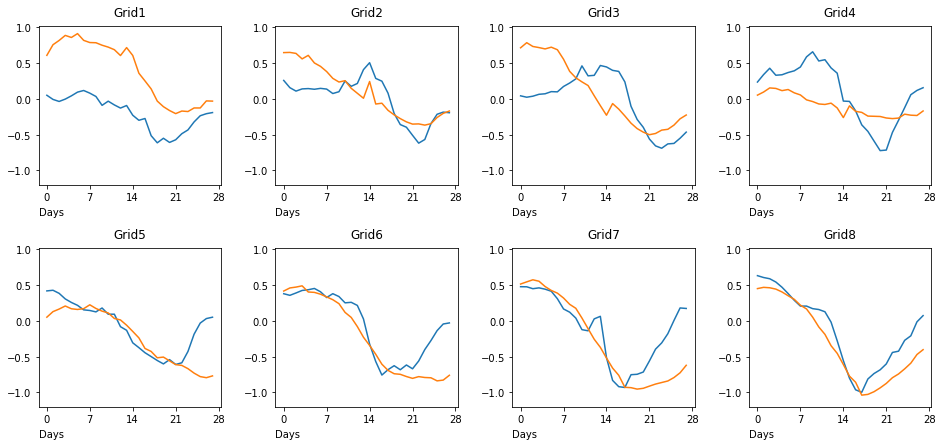

In [11]:
plot_predictions(best_gru_model, X1_test, y1_test)

In [12]:
predictions = best_gru_model.predict(X1_test).flatten()
surface_type[4,2] = 1
surface_type2 = surface_type*1.6

mapped_preds = np.empty(28, dtype = object)
    
for i in range(28):
    mapped_preds[i] = surface_type2.flatten()
    mapped_preds[i] = mapped_preds[i].astype('float')
    for j in range(187):
        mapped_preds[i][np.where(surface_type2.flatten()==0)[0][j]] = predictions[i*187:(i+1)*187][j]

mapped_y_test = np.empty(28, dtype = object)
for i in range(28):
    mapped_y_test[i] = surface_type2.flatten()
    mapped_y_test[i] = mapped_y_test[i].astype('float')
    for j in range(187):
        mapped_y_test[i][np.where(surface_type2.flatten()==0)[0][j]] = y1_test[i,j]

grids = np.empty(28, dtype = object)
for i in range(28):
    grids[i] = mapped_preds[i].reshape((s, s))

y_grid = np.empty(28, dtype = object)
for i in range(28):
    y_grid[i] = mapped_y_test[i].reshape((s, s))

................

<Figure size 576x576 with 0 Axes>

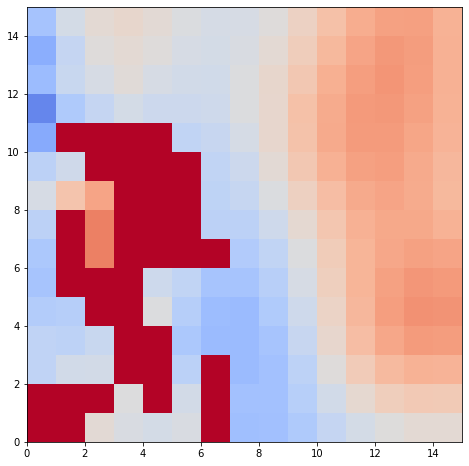

In [13]:
fps = 5
nSeconds = 6.4

grids_r = np.empty(len(grids), dtype=object)
for i in range(len(grids_r)):
    grids_r[i]= np.flip(grids[i], 0)
snapshots_p = grids_r.tolist() + 4*grids_r.tolist()[-1:] 

y_grid_r = np.empty(len(y_grid), dtype=object)
for i in range(len(y_grid_r)):
    y_grid_r[i]= np.flip(y_grid[i], 0)
snapshots_y = y_grid_r.tolist()  + 4*y_grid_r.tolist()[-1:] 

fig_p = plt.figure(figsize=(8,8))
fig_y = plt.figure(figsize=(8,8))

a_p = snapshots_p[0]
a_y = snapshots_y[0]
im_p = plt.imshow(a_p, extent=(0, 15, 0, 15), interpolation='nearest', vmin=-1.82, vmax=1.6, cmap=cm.coolwarm)
im_y = plt.imshow(a_y, extent=(0, 15, 0, 15), interpolation='nearest', vmin=-1.82, vmax=1.6, cmap=cm.coolwarm)

def animateP_func(i):
    if i % fps == 0:
        print( '.', end ='' )
    im_p.set_array(snapshots_p[i])
    return [im_p]

def animateY_func(i):
    if i % fps == 0:
        print( '.', end ='' )
    im_y.set_array(snapshots_y[i])
    return [im_y]

animP = animation.FuncAnimation(
                               fig, 
                               animateP_func, 
                               frames = int(nSeconds * fps),
                               interval = 1000 / fps
                               )

animY = animation.FuncAnimation(
                               fig, 
                               animateY_func, 
                               frames = int(nSeconds * fps),
                               interval = 1000 / fps
                               )

animP.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
animY.save('y_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

filepaths = ['C:/Users/Gil Senecaut/Desktop/UC3M/TFM/Scripts/test_anim.mp4','C:/Users/Gil Senecaut/Desktop/UC3M/TFM/Scripts/y_anim.mp4']

gsl = GridspecLayout(1, len(filepaths))

for i, filepath in enumerate(filepaths):
    video = Video.from_file(filepath, embed=True, width=500, height=500)
    gsl[0, i] = video

In [14]:
gsl

GridspecLayout(children=(Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08fr…

<p style="font-size:25px;"><b>4. Shortcomings and Improvements</b></p>